# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [2]:
import numpy as np 

#H = np.load('Hamiltonian_Example.npy')
# I have -2.0 < u 2.0 in steps of 0.1
u=4.0
t=-1
H = np.load('H_mu_'+str(u)+"_t_"+str(t)+'.npy')

In [3]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-2.10274848e+00, -1.80642385e+00, -1.06814039e+00, -8.28427125e-01,
       -8.28427125e-01,  8.70432672e-16,  5.81449281e-01,  2.00000000e+00,
        2.00000000e+00,  2.00000000e+00,  2.00000000e+00,  2.38787313e+00,
        2.96539191e+00,  3.17157288e+00,  3.17157288e+00,  4.00000000e+00,
        4.00000000e+00,  4.00000000e+00,  4.00000000e+00,  4.00000000e+00,
        4.00000000e+00,  4.82842712e+00,  4.82842712e+00,  5.03460809e+00,
        5.61212687e+00,  6.00000000e+00,  6.00000000e+00,  6.00000000e+00,
        6.00000000e+00,  7.41855072e+00,  8.00000000e+00,  8.82842712e+00,
        8.82842712e+00,  9.06814039e+00,  9.80642385e+00,  1.01027485e+01])

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [4]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [5]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [6]:
import pandas as pd

pd.DataFrame(blocks['3,3'].to_matrix())

,0,1,2,3,4,5,6,7
0,4.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,-1.0+0.0j,4.0+0.0j,-1.0+0.0j,-1.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,-1.0+0.0j,0.0+0.0j,8.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,1.0+0.0j,0.0+0.0j,-1.0+0.0j,-1.0+0.0j,4.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,4.0+0.0j,0.0+0.0j,0.0+0.0j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j,0.0+0.0j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j


In [9]:
print(blocks['0,0'])

SummedOp([
  5.5 * III,
  -0.5 * IIX,
  IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -1.5 * IZI,
  -0.5 * IZX,
  IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -0.5 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


In [43]:
blocks['0,0'][1].coeff
blocks['0,0'][1].primitive.to_label()

blocks_to_save = {}
for key in list(blocks.keys()):
    block_to_save = []
    block = blocks[key]
    for p in range(len(block)):
        pauli = block[p].primitive.to_label()
        coef = block[p].coeff
        block_to_save.append({'coef':coef, 'pauli':pauli})
    blocks_to_save[key] = block_to_save



In [44]:
import pickle


file_to_store = open("Blocks_t_"+str(t)+"_u_"+str(u)+".pickle", "wb")

pickle.dump(blocks_to_save, file_to_store)

Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [23]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-23-4f4400865c4e>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-23-4f4400865c4e>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [24]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)
pd.DataFrame(H_complete)

,0,1,2,3,4,5,6,...,41,42,43,44,45,46,47
0,8,-1,0,0,1,0,0,...,0,0,0,0,0,0,0
1,-1,4,-1,-1,0,1,0,...,0,0,0,0,0,0,0
2,0,-1,4,0,-1,0,0,...,0,0,0,0,0,0,0
3,0,-1,0,4,-1,0,0,...,0,0,0,0,0,0,0
4,1,0,-1,-1,4,-1,0,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0,0,0,0,0,0,0,...,-1,0,4,-1,0,0,0
44,0,0,0,0,0,0,0,...,0,-1,-1,4,-1,0,0
45,0,0,0,0,0,0,0,...,1,0,0,-1,8,0,0
46,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0


In [25]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

(-2.1027484834620758+0j)
-2.1027484834620758


## The Anzatz circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [26]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))


In [27]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i


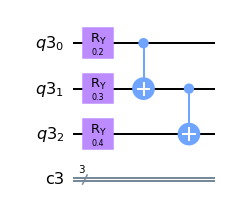

In [28]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [29]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir


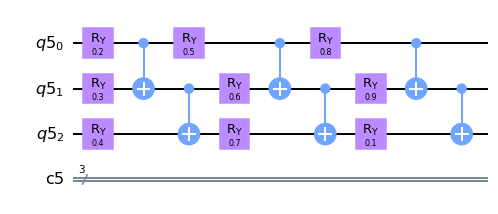

In [31]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

In order to deal with off diagonal blocks, we will also need to form $$ U^{ab} = I\otimes U^a + X \otimes U^b$$

In order to create this gate we need a controled-Ry gate.  The controled-Ry can be built as $C_{R_y}(\phi) = R_y(\phi/2)C_{NOT}R_y(-\phi/2)C_{NOT}$

In [32]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

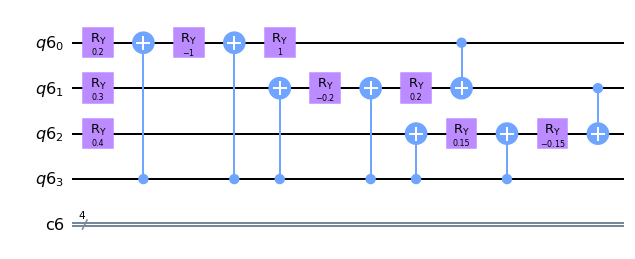

In [33]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

Let's check to make sure we are generating the right thing

In [34]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j]
B:
[0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]
AB:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j
 0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]


In [35]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

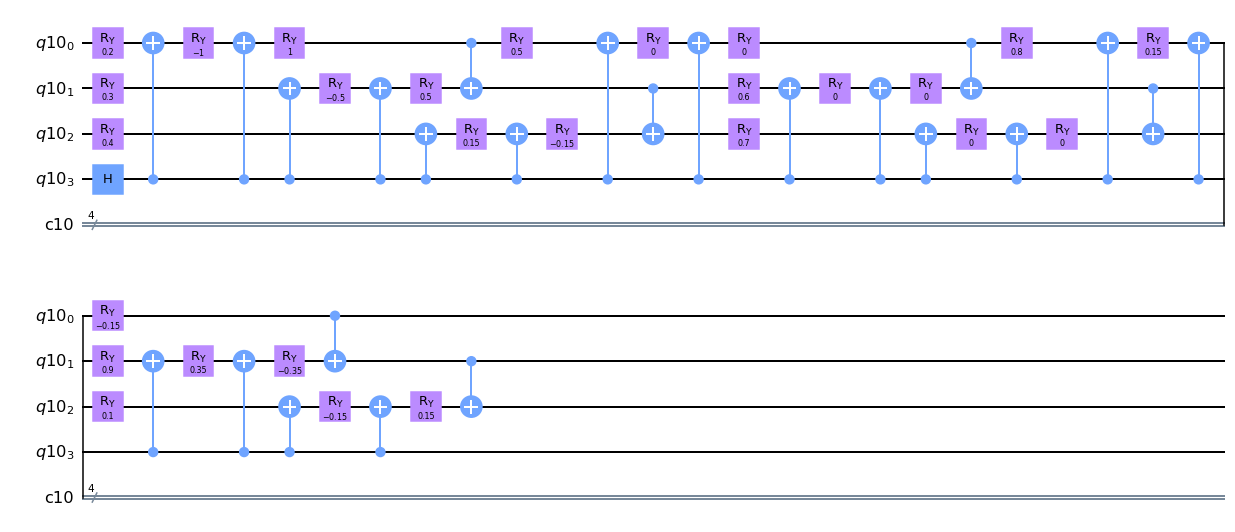

In [36]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  


To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



In [37]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        wave0 = qi.Statevector.from_instruction(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.dot(np.conjugate(wave0),np.dot(Op,wave0))
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  

#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][17].primitive.to_label()
        
    
print( measure_pauli(p_label,psi0,method = 'simple') )
print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )
#print( measure_pauli(p_label,psi0,method = 'Moon_Cheese') )

(0.7209464513295367+0j)
0.7209464513295365
0.7421875


In order to calculate things like 
$$<\psi^a|ZZ|\psi^b>$$ 
we will need to add another qubit and build the combined statevector 
$$ |\psi^{ab}> = |0>|\psi^a> + |1>|\psi_b> $$
then we can calculate
$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = <\psi^{a}|ZZ|\psi^{b}> + <\psi^{b}|ZZ|\psi^{a}>  $$ 

In order to form the combined statevector we need to create a circuit which performs 
$$ U^{ab} = I\otimes U^a + X \otimes U^b$$
This as done in the Ansatz section.   Here we will use that result to calculate E.

In [38]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

#Find the energy contribution from on diagonal blocks
def E_on_block(phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli( p_label,psi,method = method)
        E += w*E_p
    return E
        
        
block = blocks['0,0']
phi_b = phi[0]

M_b = block.to_matrix()
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,phi_b)
wave = qi.Statevector.from_instruction(psi0).data
print('check:',np.dot(np.conjugate(wave),np.dot(M_b,wave)))

print('simple:',E_on_block(phi_b,block,method = 'simple'))
print('matrix:',E_on_block(phi_b,block,method = 'matrix'))
print('simulator:',E_on_block(phi_b,block,method = 'simulator'))
#print('mooncheese:',E_on_block(phi_b,block,method = 'mooncheese'))

check: (8.104830584520121+0j)
simple: (8.10483058452012+0j)
matrix: 8.10483058452012
simulator: 8.15234375


In [39]:
# Find the energy contribution from off diagonal blocks
def E_off_block(phi_a,phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli('X' + p_label,psi,method = method)
        E += w*E_p
    return E

block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]
M_b = block.to_matrix()
#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_a = U(cir,phi_a)
wave_a = qi.Statevector.from_instruction(psi_a).data
#B
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_b = U(cir,phi_b)
wave_b = qi.Statevector.from_instruction(psi_b).data
print('check:',np.dot(np.conjugate(wave_a),np.dot(M_b,wave_b)))

print('simple:',E_off_block(phi_a,phi_b,block,method = 'simple'))
print('matrix:',E_off_block(phi_a,phi_b,block,method = 'matrix'))
print('simulator:',E_off_block(phi_a,phi_b,block,method = 'simulator'))
#print('mooncheese:',E_off_block(phi_a,phi_b,block,method = 'mooncheese'))

check: (-0.8777615398913814+0j)
simple: (-0.8777615398913812+0j)
matrix: -0.8777615398913808
simulator: -0.880859375


Now we need to add all of the blocks together

In [40]:
# The total energy 
def find_E(alpha,phi,blocks,method = 'simple'):
    E = 0
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            E += alpha[int(key[0])]*alpha[int(key[2])]*E_on_block(phi[int(key[0])],blocks[key],method = 'simple')
        else:
            E += 2*alpha[int(key[0])]*alpha[int(key[2])]*E_off_block(phi[int(key[0])],phi[int(key[2])],blocks[key],method = 'simple')
    return E
            
find_E(alpha,phi,blocks)

(4.118869428994095+0j)

In [41]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))


(4.118869428994094+0j)

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [42]:
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
find_E(alpha,phi,blocks)

(2.666666666666668+0j)

The structure of $\phi_{b,t,q}$ is by section in the first index, by number of application of $U_i$ in the second index, and by qubit in the third index


# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [43]:
import copy

In [44]:
#beta = 0.602
beta = 0.201
A = 10
a = 0.05
gamma = 0.101
c = 0.4

beta_a = 0.201
A_a = 10
a_a = 0.05
gamma_a = 0.101
c_a = 0.4

def SPSA(k_max,method = 'simple',hold = False):
    np.random.seed(10)
    
    #Initalization
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
            
        #Find E    
        E_A = find_E(alpha_k_A, phi_k_A, blocks, method = method)
        E_B = find_E(alpha_k_B, phi_k_B, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Calculate new E
        E_f = np.real(find_E(alpha_k,phi_k,blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [45]:
out = SPSA(3000,method = 'simple',hold = True)

k= 0 c_k= 0.4 a_k= 0.030878064824598282 g= -0.6781462766562452 E_A= (3.2791464800352705+0j) E_B= (3.8216635013602667+0j) E_f= 2.623809713424678
k= 1 c_k= 0.372954594574733 a_k= 0.030342724499598534 g= 3.0537900082921277 E_A= (5.361323002190761+0j) E_B= (3.0834729732728388+0j) E_f= 2.2425297300603715
k= 2 c_k= 0.3579898757427053 a_k= 0.029858459038837503 g= -0.5753357861198101 E_A= (3.412128468666559+0j) E_B= (3.824057241833284+0j) E_f= 2.265964783874999
k= 3 c_k= 0.34773782403600867 a_k= 0.029416992458941946 g= -0.5227340376727513 E_A= (3.161730791897202+0j) E_B= (3.525279585516961+0j) E_f= 2.2772392521967895
k= 4 c_k= 0.33998833831625347 a_k= 0.02901186589249766 g= -0.24648644962432806 E_A= (3.3979914630735215+0j) E_B= (3.565596499924018+0j) E_f= 2.2951238902456805
k= 5 c_k= 0.3337849224236992 a_k= 0.028637947449493925 g= 7.181511586463385 E_A= (7.275702321504376+0j) E_B= (2.4815417459592197+0j) E_f= 2.1331797421565817
k= 6 c_k= 0.32862839767254015 a_k= 0.028291095918097278 g= -0.6754

k= 52 c_k= 0.267860162826851 a_k= 0.021742153317333094 g= 3.3184393174343274 E_A= (3.1054349929403617+0j) E_B= (1.3276796011423955+0j) E_f= 0.6239550914769434
k= 53 c_k= 0.26735494522142605 a_k= 0.021673439087867164 g= -0.954511357333334 E_A= (2.16882520399751+0j) E_B= (2.679211867303675+0j) E_f= 0.6930834208316987
k= 54 c_k= 0.2668599250350944 a_k= 0.02160600238280336 g= 1.8988337127080548 E_A= (2.3911840705428453+0j) E_B= (1.3777388260880823+0j) E_f= 0.6376164398457309
k= 55 c_k= 0.26637471655715955 a_k= 0.021539800337028216 g= 5.175740977692463 E_A= (3.5254078030690987+0j) E_B= (0.7680347312568874+0j) E_f= 0.3864472717582783
k= 56 c_k= 0.2658989552298248 a_k= 0.02147479214577462 g= -3.5230643467663674 E_A= (0.9731168212891688+0j) E_B= (2.8466750793144135+0j) E_f= 0.24067515043047052
k= 57 c_k= 0.26543229614067565 a_k= 0.021410938936572577 g= -3.114044047563795 E_A= (1.6039590327592133+0j) E_B= (3.257094756415336+0j) E_f= 0.2844385125778869
k= 58 c_k= 0.26497441264651617 a_k= 0.02134

k= 103 c_k= 0.25023014297472496 a_k= 0.019298881045265278 g= -3.1423808061862513 E_A= (0.5327437677500628+0j) E_B= (2.1053805645760972+0j) E_f= -0.175372539585997
k= 104 c_k= 0.24998840873867942 a_k= 0.019265032163888564 g= 1.07287639955791 E_A= (1.7679228465472667+0j) E_B= (1.2315095187497356+0j) E_f= -0.15990338896455736
k= 105 c_k= 0.24974919607452548 a_k= 0.01923153495014902 g= 1.0298289247699808 E_A= (1.3755241482691825+0j) E_B= (0.8611262561579911+0j) E_f= -0.2220817386259809
k= 106 c_k= 0.2495124552599996 a_k= 0.01919838276571559 g= -3.4032063182565757 E_A= (0.41546201301903174+0j) E_B= (2.1137467414681153+0j) E_f= -0.2509873978702961
k= 107 c_k= 0.24927813800651724 a_k= 0.019165569152951475 g= 0.40764568441360055 E_A= (1.2775160211668781+0j) E_B= (1.0742817068128487+0j) E_f= -0.23121158719574367
k= 108 c_k= 0.24904619740500722 a_k= 0.01913308782851349 g= -4.065923581941515 E_A= (0.9648392604824345+0j) E_B= (2.9900448745261956+0j) E_f= -0.19385595495518484
k= 109 c_k= 0.24881658

k= 154 c_k= 0.24034577371294386 a_k= 0.017916605514221893 g= -2.037983118274875 E_A= (0.7999150229594914+0j) E_B= (1.7795562817108768+0j) E_f= -0.3119575278689745
k= 155 c_k= 0.2401897150315199 a_k= 0.017894858911911237 g= -1.130074115577956 E_A= (1.242969859790181+0j) E_B= (1.7858342193605132+0j) E_f= -0.257959445400637
k= 156 c_k= 0.24003475389827156 a_k= 0.017873269078684573 g= -0.09179529089526631 E_A= (1.4201619668234762+0j) E_B= (1.4642300869416072+0j) E_f= -0.2636062150732163
k= 157 c_k= 0.23988087567680955 a_k= 0.017851833955768864 g= -3.1061078485101623 E_A= (0.3304530355584763+0j) E_B= (1.8206447768529335+0j) E_f= -0.25819316065032577
k= 158 c_k= 0.239728066017013 a_k= 0.01783055152347874 g= 3.0465547161585746 E_A= (2.2547682749095834+0j) E_B= (0.7940789346701733+0j) E_f= -0.20503240072320986
k= 159 c_k= 0.23957631084767136 a_k= 0.01780941980024826 g= -3.3761885991854634 E_A= (0.5819277676517132+0j) E_B= (2.199637386289355+0j) E_f= -0.2858747006112882
k= 160 c_k= 0.2394255963

k= 205 c_k= 0.23353899237344763 a_k= 0.016972460255372947 g= 0.6063712695911203 E_A= (1.5224604792088183+0j) E_B= (1.2392378085997815+0j) E_f= -0.3294310048714992
k= 206 c_k= 0.23342479519724088 a_k= 0.016956710197876357 g= 1.8803941295013966 E_A= (1.8283732296662425+0j) E_B= (0.9505120005283274+0j) E_f= -0.31949008207092244
k= 207 c_k= 0.23331120380879006 a_k= 0.016941047069765323 g= 1.601451144012685 E_A= (1.3515418390906608+0j) E_B= (0.6042688505895336+0j) E_f= -0.30813119925949317
k= 208 c_k= 0.2331982121051757 a_k= 0.016925469995779104 g= -0.6080158619954867 E_A= (1.2534246075296807+0j) E_B= (1.5370010314275502+0j) E_f= -0.2857626499878277
k= 209 c_k= 0.23308581407379206 a_k= 0.016909978113415238 g= 3.974921958015943 E_A= (2.1190357166534586+0j) E_B= (0.2660398757255832+0j) E_f= -0.4021204125346026
k= 210 c_k= 0.232974003790588 a_k= 0.01689457057268661 g= 0.49590496789199573 E_A= (1.1760271874484554+0j) E_B= (0.9449612557095729+0j) E_f= -0.4195524972399075
k= 211 c_k= 0.2328627754

k= 256 c_k= 0.22837930441497245 a_k= 0.01626451962299262 g= -1.9335641689299887 E_A= (0.7361368217325817+0j) E_B= (1.619308901616472+0j) E_f= -0.2874271403783254
k= 257 c_k= 0.22828974396591784 a_k= 0.016252303008687845 g= 3.7387956939777705 E_A= (2.0502868108401158+0j) E_B= (0.3432293874019933+0j) E_f= -0.39374342716862176
k= 258 c_k= 0.22820056489801344 a_k= 0.01624014101894129 g= -2.9478078553228038 E_A= (0.7083936091602357+0j) E_B= (2.053776444751166+0j) E_f= -0.3652843322978174
k= 259 c_k= 0.22811176412405826 a_k= 0.01622803320780049 g= -4.272391701899902 E_A= (0.06281160535792377+0j) E_B= (2.011977221656672+0j) E_f= -0.45860764923039354
k= 260 c_k= 0.22802333859359442 a_k= 0.016215979134588294 g= 0.7219842915235745 E_A= (0.8120966139438297+0j) E_B= (0.48283807681315694+0j) E_f= -0.4429582503808056
k= 261 c_k= 0.22793528529233112 a_k= 0.016203978363821238 g= -1.4021789008840035 E_A= (0.5913821123656006+0j) E_B= (1.2305942079733658+0j) E_f= -0.41116897621924164
k= 262 c_k= 0.227847

k= 307 c_k= 0.2242416957476633 a_k= 0.015702982735919514 g= -4.3905142171774765 E_A= (0.3865346151119493+0j) E_B= (2.355607321640153+0j) E_f= -0.27623073478883375
k= 308 c_k= 0.22416829307647623 a_k= 0.015693075965474278 g= 1.1243405210850996 E_A= (1.2606751829328597+0j) E_B= (0.7565921920361345+0j) E_f= -0.2390333700245712
k= 309 c_k= 0.22409515148215373 a_k= 0.015683206422906985 g= 3.3004767481968322 E_A= (1.7763743808831713+0j) E_B= (0.29713270718218104+0j) E_f= -0.2612437418525063
k= 310 c_k= 0.2240222691984007 a_k= 0.01567337385263873 g= 2.0292634226355624 E_A= (1.4710254855897733+0j) E_B= (0.5618250921095094+0j) E_f= -0.26064192946991743
k= 311 c_k= 0.2239496444765029 a_k= 0.015663578001634454 g= -0.7141783623570781 E_A= (1.0259519970313886+0j) E_B= (1.345831977716746+0j) E_f= -0.23664750393932535
k= 312 c_k= 0.22387727558509607 a_k= 0.015653818619369854 g= -1.7165528267814276 E_A= (0.5165421334416604+0j) E_B= (1.2851364739571032+0j) E_f= -0.25302717287018667
k= 313 c_k= 0.223805

k= 358 c_k= 0.22079816106773162 a_k= 0.015240446991449733 g= -0.763006929955693 E_A= (1.0284032673219032+0j) E_B= (1.3653443213542082+0j) E_f= -0.33545934961160145
k= 359 c_k= 0.22073613743405993 a_k= 0.015232158767708136 g= -2.3041542160643953 E_A= (0.26949690360055306+0j) E_B= (1.2867171070134709+0j) E_f= -0.3613679636959559
k= 360 c_k= 0.22067430319994108 a_k= 0.015223897403529201 g= 2.934686551655527 E_A= (1.8812915248664337+0j) E_B= (0.586071705072791+0j) E_f= -0.36048730832774784
k= 361 c_k= 0.2206126572647566 a_k= 0.015215662739822751 g= -2.9095825365796735 E_A= (0.5164491246945313+0j) E_B= (1.8002305945464765+0j) E_f= -0.3925212662656463
k= 362 c_k= 0.2205511985373019 a_k= 0.015207454618865354 g= 1.9444429778395957 E_A= (1.1479776343913695+0j) E_B= (0.29027917589144303+0j) E_f= -0.3698418635885925
k= 363 c_k= 0.22048992593568012 a_k= 0.015199272884284947 g= 3.7545611802393037 E_A= (2.0883186634240687+0j) E_B= (0.432632830320181+0j) E_f= -0.39119962660570545
k= 364 c_k= 0.220428

k= 409 c_k= 0.21785564705344662 a_k= 0.014848989391098043 g= -4.830077604334899 E_A= (0.3344300472171823+0j) E_B= (2.438949410838664+0j) E_f= -0.45563010586306973
k= 410 c_k= 0.2178020521092889 a_k= 0.014841893231637726 g= 0.80968554062148 E_A= (1.0062811692055647+0j) E_B= (0.65357882458441+0j) E_f= -0.4473374884296567
k= 411 c_k= 0.21774860054507708 a_k= 0.01483481728679895 g= -2.4073074317233614 E_A= (0.45825923670497026+0j) E_B= (1.5066348853840215+0j) E_f= -0.4289914018505536
k= 412 c_k= 0.21769529163061768 a_k= 0.014827761451299215 g= 0.8579307312956804 E_A= (1.1987773827819772+0j) E_B= (0.8252424212854127+0j) E_f= -0.4134579679719702
k= 413 c_k= 0.21764212464119265 a_k= 0.014820725620651613 g= 0.5287773988297019 E_A= (1.0402486461019753+0j) E_B= (0.8100801730148961+0j) E_f= -0.4000202426835313
k= 414 c_k= 0.217589098857505 a_k= 0.014813709691156947 g= 0.33426734098311317 E_A= (0.6644064099523987+0j) E_B= (0.5189405509483789+0j) E_f= -0.3954926080036616
k= 415 c_k= 0.2175362135656

k= 460 c_k= 0.21529116004852789 a_k= 0.014510848303116568 g= -1.5400029693072053 E_A= (0.3499159796966903+0j) E_B= (1.0130140311773417+0j) E_f= -0.4026312486355982
k= 461 c_k= 0.2152440483769229 a_k= 0.014504663658363552 g= 0.8598478805133483 E_A= (1.0287284097135252+0j) E_B= (0.6585741321335057+0j) E_f= -0.37469088499576747
k= 462 c_k= 0.21519704884440038 a_k= 0.014498494730401415 g= 1.8303193840879302 E_A= (1.230825926502262+0j) E_B= (0.4430672667054159+0j) E_f= -0.35850239239274617
k= 463 c_k= 0.21515016094269962 a_k= 0.01449234144618824 g= -0.4074791773036079 E_A= (0.5389354361792356+0j) E_B= (0.7142738573345757+0j) E_f= -0.3491789060286423
k= 464 c_k= 0.21510338416695282 a_k= 0.014486203733174744 g= -1.5610409410879038 E_A= (0.7748374047894708+0j) E_B= (1.4464077832918167+0j) E_f= -0.32527424716070674
k= 465 c_k= 0.215056718015655 a_k= 0.014480081519299942 g= -1.8031046232344965 E_A= (0.6211274406055018+0j) E_B= (1.3966669656288317+0j) E_f= -0.2992286210839029
k= 466 c_k= 0.215010

k= 511 c_k= 0.21302164067868354 a_k= 0.014214062909299498 g= -2.2322772248564675 E_A= (0.6517703446289892+0j) E_B= (1.6028170584061556+0j) E_f= -0.3880579196653069
k= 512 c_k= 0.21297966395158172 a_k= 0.014208595965656191 g= -2.1446493928486285 E_A= (0.3894012197929801+0j) E_B= (1.3029346337587095+0j) E_f= -0.3683560424525008
k= 513 c_k= 0.21293777721836393 a_k= 0.014203141561731296 g= -0.33094140443806025 E_A= (0.7523573544620986+0j) E_B= (0.8932972085632269+0j) E_f= -0.3651842238455806
k= 514 c_k= 0.21289598011156907 a_k= 0.014197699644913457 g= 0.7906217071922709 E_A= (0.7945536950341563+0j) E_B= (0.45791332853379535+0j) E_f= -0.3436196104398823
k= 515 c_k= 0.2128542722659462 a_k= 0.014192270162911738 g= 2.4234985327686873 E_A= (1.407140774098484+0j) E_B= (0.37543674103834934+0j) E_f= -0.36324379851987176
k= 516 c_k= 0.21281265331843718 a_k= 0.014186853063753052 g= -2.4464644665494824 E_A= (0.20416333056403524+0j) E_B= (1.2454405193153761+0j) E_f= -0.4248106182567518
k= 517 c_k= 0.2

k= 562 c_k= 0.21098843143819737 a_k= 0.013950215781679329 g= -3.2964537998853385 E_A= (0.20082898385565315+0j) E_B= (1.591856216948239+0j) E_f= -0.4280124433368154
k= 563 c_k= 0.21095061790221384 a_k= 0.013945327372318217 g= 3.115266274517545 E_A= (1.3092701600123848+0j) E_B= (-0.005064531066422878+0j) E_f= -0.45523415951972934
k= 564 c_k= 0.21091287811113657 a_k= 0.013940449180459964 g= 1.7131284435130194 E_A= (1.0933358454319204+0j) E_B= (0.3706941442411553+0j) E_f= -0.42742203962005776
k= 565 c_k= 0.21087521179100568 a_k= 0.013935581167034524 g= -0.30972307566171864 E_A= (0.6904812098713881+0j) E_B= (0.8211070482248413+0j) E_f= -0.41774686169114217
k= 566 c_k= 0.21083761866936074 a_k= 0.013930723293188747 g= 2.6546894863342474 E_A= (1.1696578838384646+0j) E_B= (0.050241064627862105+0j) E_f= -0.45937495625217756
k= 567 c_k= 0.21080009847523 a_k= 0.013925875520284806 g= 1.548541032762936 E_A= (1.1553519889081827+0j) E_B= (0.50248678450946+0j) E_f= -0.4575923849400524
k= 568 c_k= 0.210

k= 613 c_k= 0.209148611557505 a_k= 0.013713171322627967 g= -0.8474463949935439 E_A= (0.6294185753562314+0j) E_B= (0.9839030491208567+0j) E_f= -0.355172891016381
k= 614 c_k= 0.20911423844352794 a_k= 0.013708758345051218 g= -1.785935493817072 E_A= (0.5999772911878848+0j) E_B= (1.3469063725855308+0j) E_f= -0.364135759237959
k= 615 c_k= 0.20907992681080098 a_k= 0.013704353839315616 g= -0.6081865623989052 E_A= (0.48237545645528507+0j) E_B= (0.7366946603626365+0j) E_f= -0.3512224125325226
k= 616 c_k= 0.2090456764498162 a_k= 0.013699957775662911 g= -2.9068967318066528 E_A= (0.3632512357611791+0j) E_B= (1.5785996231017425+0j) E_f= -0.3725069260071008
k= 617 c_k= 0.2090114871521178 a_k= 0.013695570124486635 g= 0.20476840752332703 E_A= (0.6533728899221052+0j) E_B= (0.5677749911656622+0j) E_f= -0.36985189311196215
k= 618 c_k= 0.20897735871029496 a_k= 0.013691190856331083 g= 0.6943825878450217 E_A= (0.8119698035569549+0j) E_B= (0.5217493252724109+0j) E_f= -0.36786209169895023
k= 619 c_k= 0.2089432

k= 664 c_k= 0.20746985582846092 a_k= 0.013498327036766226 g= -1.4711422472609392 E_A= (0.22176431995173873+0j) E_B= (0.8321996598365089+0j) E_f= -0.4456578078057273
k= 665 c_k= 0.2074383714266899 a_k= 0.013494311106923366 g= 3.176633397092908 E_A= (1.3152269901246645+0j) E_B= (-0.0026843269005082902+0j) E_f= -0.482769149437249
k= 666 c_k= 0.2074069390304888 a_k= 0.013490302305560734 g= -1.0858315179805438 E_A= (0.3641476083294603+0j) E_B= (0.8145655912238078+0j) E_f= -0.46733488591528816
k= 667 c_k= 0.20737555847617897 a_k= 0.013486300609523402 g= 1.3014589893219777 E_A= (0.747378907329104+0j) E_B= (0.20759733784012677+0j) E_f= -0.4742591789364672
k= 668 c_k= 0.207344229600841 a_k= 0.013482305995765657 g= 2.155759507067815 E_A= (1.381143295652045+0j) E_B= (0.48717470725671536+0j) E_f= -0.4617012057588232
k= 669 c_k= 0.20731295224231006 a_k= 0.013478318441350348 g= 1.095086673646913 E_A= (0.9121768774093124+0j) E_B= (0.45812557485940714+0j) E_f= -0.45401861550387806
k= 670 c_k= 0.207281

k= 715 c_k= 0.2059272292361946 a_k= 0.013302147022313223 g= 0.9659265185994494 E_A= (0.9048261678877262+0j) E_B= (0.5070050246458297+0j) E_f= -0.4090289775954671
k= 716 c_k= 0.2058982031543004 a_k= 0.013298467239603848 g= -3.0900723608377305 E_A= (0.10710418965778915+0j) E_B= (1.3795848830843007+0j) E_f= -0.43676838550919744
k= 717 c_k= 0.20586922160965612 a_k= 0.013294793530859871 g= -0.4135498831113803 E_A= (0.6345388118960169+0j) E_B= (0.8048131969618252+0j) E_f= -0.4296538634980651
k= 718 c_k= 0.20584028447203734 a_k= 0.01329112587773268 g= 1.7807494603495124 E_A= (1.157715660045382+0j) E_B= (0.4246157090618408+0j) E_f= -0.4069759118612222
k= 719 c_k= 0.20581139161178091 a_k= 0.013287464261954176 g= 1.4171082249618325 E_A= (1.303747880742366+0j) E_B= (0.720433849054575+0j) E_f= -0.3932598473122487
k= 720 c_k= 0.20578254289978168 a_k= 0.01328380866533629 g= 2.3094301784835927 E_A= (1.4189694194018274+0j) E_B= (0.46848858984612674+0j) E_f= -0.39830795428389376
k= 721 c_k= 0.205753738

k= 766 c_k= 0.20450110526148496 a_k= 0.013121859386471675 g= -0.7576890971215223 E_A= (0.4411204169336382+0j) E_B= (0.7510169325454941+0j) E_f= -0.4305607886818674
k= 767 c_k= 0.20447419548222823 a_k= 0.013118467549550872 g= 1.3068945566959789 E_A= (0.8862695908676469+0j) E_B= (0.3518171647466197+0j) E_f= -0.42878234904987755
k= 768 c_k= 0.20444732425304057 a_k= 0.013115080944577811 g= 1.77538675022384 E_A= (1.0486671202393454+0j) E_B= (0.3227209790442146+0j) E_f= -0.4167630118544682
k= 769 c_k= 0.20442049146867386 a_k= 0.013111699556781438 g= -1.1319090359737276 E_A= (0.4539144742767322+0j) E_B= (0.9166852771398967+0j) E_f= -0.4096798850488961
k= 770 c_k= 0.2043936970243036 a_k= 0.013108323371451269 g= -0.03660131892137763 E_A= (0.6260730423065182+0j) E_B= (0.6410352000871301+0j) E_f= -0.4102889055885862
k= 771 c_k= 0.20436694081552656 a_k= 0.013104952373937068 g= 2.2249616205948377 E_A= (1.104917998953194+0j) E_B= (0.19550079928734757+0j) E_f= -0.4074369552773631
k= 772 c_k= 0.204340

k= 817 c_k= 0.20317576687976258 a_k= 0.012955253238817114 g= 1.0785437358955856 E_A= (0.7089991194121039+0j) E_B= (0.2707312181042044+0j) E_f= -0.4650423489237639
k= 818 c_k= 0.20315069725365983 a_k= 0.012952110582972312 g= -0.2238694500419139 E_A= (0.41608509258099396+0j) E_B= (0.5070435623206103+0j) E_f= -0.46111564897169544
k= 819 c_k= 0.20312566130658577 a_k= 0.01294897247670345 g= 1.716781121153563 E_A= (1.0923962672017642+0j) E_B= (0.3949516660958057+0j) E_f= -0.46625830244705513
k= 820 c_k= 0.20310065895230606 a_k= 0.012945838907954647 g= -0.7657001968409172 E_A= (0.5409749519146956+0j) E_B= (0.852003380991297+0j) E_f= -0.45073801545992054
k= 821 c_k= 0.20307569010491178 a_k= 0.012942709864716429 g= 1.7441231447806438 E_A= (0.9923930424165308+0j) E_B= (0.2840150199079745+0j) E_f= -0.43542601695757743
k= 822 c_k= 0.20305075467881792 a_k= 0.012939585335025493 g= 1.272922131631381 E_A= (1.054587909705613+0j) E_B= (0.53765231075537+0j) E_f= -0.4177436188879176
k= 823 c_k= 0.20302585

k= 868 c_k= 0.20193843858172422 a_k= 0.01280053850819599 g= 2.5245916232382557 E_A= (1.4430550731139997+0j) E_B= (0.4234308922075318+0j) E_f= -0.4527919305496835
k= 869 c_k= 0.20191498303253896 a_k= 0.012797613420606676 g= 0.4574436639235567 E_A= (0.6966367831626591+0j) E_B= (0.5119073238837243+0j) E_f= -0.44292004934901136
k= 870 c_k= 0.20189155714799123 a_k= 0.012794692322375598 g= 2.5079908611620767 E_A= (1.1970125935346951+0j) E_B= (0.18432823298880904+0j) E_f= -0.4520862453421001
k= 871 c_k= 0.20186816085657003 a_k= 0.012791775203542945 g= 0.7790620830330423 E_A= (0.7118383083801257+0j) E_B= (0.3973026485901884+0j) E_f= -0.4392700007661496
k= 872 c_k= 0.20184479408701855 a_k= 0.012788862054185014 g= 0.46786665088795426 E_A= (0.6300759474363794+0j) E_B= (0.44120305181905517+0j) E_f= -0.43135581055443617
k= 873 c_k= 0.20182145676833294 a_k= 0.012785952864414066 g= -2.7275689748910383 E_A= (0.2322357723373475+0j) E_B= (1.3331996602345833+0j) E_f= -0.45908229452129357
k= 874 c_k= 0.20

k= 919 c_k= 0.20077859959856656 a_k= 0.012656246700588522 g= 0.4288115222817807 E_A= (0.6574109893211847+0j) E_B= (0.4852186354502538+0j) E_f= -0.3810309529503032
k= 920 c_k= 0.20075657077936174 a_k= 0.012653513083078383 g= -0.4014412210900977 E_A= (0.5220089061656671+0j) E_B= (0.6831928319967223+0j) E_f= -0.3780230498135504
k= 921 c_k= 0.20073456827855668 a_k= 0.012650782989691713 g= -2.141019643237152 E_A= (0.2975725722638839+0j) E_B= (1.1571258797861221+0j) E_f= -0.39663266825852717
k= 922 c_k= 0.2007125920362143 a_k= 0.012648056412111338 g= -3.4256728315291394 E_A= (0.13483660767929834+0j) E_B= (1.509987954647801+0j) E_f= -0.41121912258462445
k= 923 c_k= 0.20069064199259876 a_k= 0.012645333342048608 g= -1.867079233937591 E_A= (0.4250634133402078+0j) E_B= (1.174474073560177+0j) E_f= -0.39649691554852673
k= 924 c_k= 0.2006687180881746 a_k= 0.012642613771243252 g= 1.6028091767333645 E_A= (1.2712648363533066+0j) E_B= (0.6279975106832131+0j) E_f= -0.39592679712264073
k= 925 c_k= 0.20064

k= 970 c_k= 0.19968748586985427 a_k= 0.012521159097453233 g= 2.153906667007975 E_A= (0.9168856780240208+0j) E_B= (0.05666926375774086+0j) E_f= -0.4669631821628458
k= 971 c_k= 0.19966672684823328 a_k= 0.01251859516926913 g= -1.3303802188459986 E_A= (0.11667147453994783+0j) E_B= (0.6479368020611814+0j) E_f= -0.4740631595369333
k= 972 c_k= 0.19964599132738334 a_k= 0.012516034374889878 g= -0.7792610576510588 E_A= (0.29176411530773044+0j) E_B= (0.6029168080228722+0j) E_f= -0.469955139219885
k= 973 c_k= 0.19962527925658788 a_k= 0.012513476707302976 g= -0.6256495870702309 E_A= (0.16224093798002506+0j) E_B= (0.4120318850513525+0j) E_f= -0.4669434028561263
k= 974 c_k= 0.19960459058529167 a_k= 0.012510922159518708 g= -1.8156056180083207 E_A= (0.16417607342877646+0j) E_B= (0.8889825055225891+0j) E_f= -0.46010097010219786
k= 975 c_k= 0.1995839252631003 a_k= 0.012508370724570072 g= 1.210238610451443 E_A= (0.8672417511131901+0j) E_B= (0.3841534063554718+0j) E_f= -0.4644040027908928
k= 976 c_k= 0.199

k= 1020 c_k= 0.19867736497116498 a_k= 0.012396669206395186 g= -0.4005035045727372 E_A= (0.6708275373539542+0j) E_B= (0.8299694992544109+0j) E_f= -0.4434668187988501
k= 1021 c_k= 0.19865772187427627 a_k= 0.01239425380363245 g= 1.4881185825279977 E_A= (0.8937457999304319+0j) E_B= (0.3024933049628536+0j) E_f= -0.4534283334420922
k= 1022 c_k= 0.19863809992749498 a_k= 0.012391841210183788 g= 0.2700424634635698 E_A= (0.5757139281758867+0j) E_B= (0.46843248449159974+0j) E_f= -0.4496838633660906
k= 1023 c_k= 0.19861849908740717 a_k= 0.01238943142006691 g= -0.9088314386870728 E_A= (0.516699184379296+0j) E_B= (0.8777206569302466+0j) E_f= -0.44245975043390906
k= 1024 c_k= 0.1985989193107303 a_k= 0.012387024427318025 g= -2.506333619820213 E_A= (0.07303823340797333+0j) E_B= (1.0685485300648634+0j) E_f= -0.45626719354700057
k= 1025 c_k= 0.19857936055431258 a_k= 0.012384620225991782 g= -0.8771047791459197 E_A= (0.24800181622267034+0j) E_B= (0.5963516285865269+0j) E_f= -0.4523339322785074
k= 1026 c_k=

k= 1070 c_k= 0.19772029728292054 a_k= 0.012279227334335188 g= -1.7927011502204329 E_A= (0.24764772195178597+0j) E_B= (0.9565545306738211+0j) E_f= -0.5229938917788514
k= 1071 c_k= 0.1977016609690369 a_k= 0.012276945415213545 g= -1.9225398685749928 E_A= (0.049407541548148526+0j) E_B= (0.8095861921410885+0j) E_f= -0.5178597798181717
k= 1072 c_k= 0.19768304378579968 a_k= 0.012274666027575317 g= -1.0681251388637625 E_A= (0.443588841618001+0j) E_B= (0.865889298807438+0j) E_f= -0.511549669597353
k= 1073 c_k= 0.19766444569576908 a_k= 0.01227238916627857 g= -0.11626245093395014 E_A= (0.5787174417709504+0j) E_B= (0.624679347609132+0j) E_f= -0.5141681527104623
k= 1074 c_k= 0.1976458666616134 a_k= 0.012270114826196556 g= -0.3396234663230641 E_A= (0.5888293318314842+0j) E_B= (0.7230796805115708+0j) E_f= -0.5083803025239328
k= 1075 c_k= 0.19762730664610859 a_k= 0.012267843002217638 g= 2.1110764304839704 E_A= (0.913296157544698+0j) E_B= (0.07888345938344216+0j) E_f= -0.49680048226289564
k= 1076 c_k= 

k= 1120 c_k= 0.1968112068509547 a_k= 0.012168135038436745 g= -0.7099288591683667 E_A= (0.4224541973685869+0j) E_B= (0.7018981084710824+0j) E_f= -0.5233360315812424
k= 1121 c_k= 0.19679348323245027 a_k= 0.012165973679109425 g= -1.3587852764101909 E_A= (0.30685895354163367+0j) E_B= (0.841659128561092+0j) E_f= -0.5124779265757385
k= 1122 c_k= 0.196775776997312 a_k= 0.012163814611669533 g= 1.7785438875314006 E_A= (0.8749504250441479+0j) E_B= (0.1750017142585255+0j) E_f= -0.5110369001399622
k= 1123 c_k= 0.19675808811303366 a_k= 0.012161657831667139 g= -1.716865722293717 E_A= (0.20299945010579357+0j) E_B= (0.8786138842364222+0j) E_f= -0.5006772164831348
k= 1124 c_k= 0.19674041654719857 a_k= 0.012159503334664867 g= 1.6760479130499932 E_A= (0.9095499192075875+0j) E_B= (0.2500571900745506+0j) E_f= -0.5013920180760902
k= 1125 c_k= 0.19672276226747937 a_k= 0.012157351116237846 g= 0.6358414080816385 E_A= (0.6831218708959986+0j) E_B= (0.43295291457227164+0j) E_f= -0.4963318963259319
k= 1126 c_k= 0.

k= 1170 c_k= 0.19594570340030806 a_k= 0.012062790211648718 g= 0.4917022482998218 E_A= (0.6232210538174735+0j) E_B= (0.43052716800423046+0j) E_f= -0.5041081140501525
k= 1171 c_k= 0.19592881081459984 a_k= 0.012060738231329292 g= -1.0828067745999104 E_A= (0.10465727522513166+0j) E_B= (0.5289633626038375+0j) E_f= -0.5034685683925422
k= 1172 c_k= 0.19591193409067234 a_k= 0.012058688334916155 g= 1.8721917763622689 E_A= (0.8172827199193596+0j) E_B= (0.08371329612779246+0j) E_f= -0.49835319348097373
k= 1173 c_k= 0.19589507320012842 a_k= 0.012056640518534122 g= 1.4377599486264367 E_A= (0.6841178926553503+0j) E_B= (0.12081771189457288+0j) E_f= -0.492087573258693
k= 1174 c_k= 0.19587822811464575 a_k= 0.012054594778318465 g= -2.3051400816445677 E_A= (0.1327544408895446+0j) E_B= (1.0358079503867201+0j) E_f= -0.5041184357288895
k= 1175 c_k= 0.19586139880597675 a_k= 0.012052551110414906 g= -1.5885009797219976 E_A= (0.4014756481503424+0j) E_B= (1.0237276959363724+0j) E_f= -0.4991227496384544
k= 1176 c

k= 1220 c_k= 0.19511996493989248 a_k= 0.011962670362596843 g= 1.8672193031543713 E_A= (0.9475844083899948+0j) E_B= (0.21892087845685207+0j) E_f= -0.47040143460792655
k= 1221 c_k= 0.19510383206814602 a_k= 0.011960718027509566 g= -2.4761208640329277 E_A= (0.25894341155592904+0j) E_B= (1.225144750029355+0j) E_f= -0.4764977163583571
k= 1222 c_k= 0.195087713725283 a_k= 0.01195876759470504 g= -0.22561516394265116 E_A= (0.2767029230116768+0j) E_B= (0.36473241604233025+0j) E_f= -0.4719120427428096
k= 1223 c_k= 0.19507160988635527 a_k= 0.011956819060789192 g= 2.030712954308866 E_A= (0.987653918224631+0j) E_B= (0.19538502779641675+0j) E_f= -0.4848351249093651
k= 1224 c_k= 0.19505552052647807 a_k= 0.011954872422376755 g= -0.026905262284042487 E_A= (0.35249941370910953+0j) E_B= (0.3629954535885402+0j) E_f= -0.4842985468414164
k= 1225 c_k= 0.19503944562082945 a_k= 0.011952927676091227 g= -0.2991730001782084 E_A= (0.2789924690198612+0j) E_B= (0.39569354121881734+0j) E_f= -0.47927777955520706
k= 1226

k= 1270 c_k= 0.1943306443684955 a_k= 0.011867319346025099 g= -0.5479822633956408 E_A= (0.20081535181522364+0j) E_B= (0.41379484451158666+0j) E_f= -0.4860541786913606
k= 1271 c_k= 0.1943152085709534 a_k= 0.011865458133186391 g= -0.9710121535035419 E_A= (0.3802098118832605+0j) E_B= (0.7575746701492032+0j) E_f= -0.4770573223032436
k= 1272 c_k= 0.19429978612833498 a_k= 0.011863598663148206 g= 0.21852300280105122 E_A= (0.3840503194743313+0j) E_B= (0.29913237405759974+0j) E_f= -0.4804447615732024
k= 1273 c_k= 0.19428437701860826 a_k= 0.011861740932922145 g= -2.0717424702911176 E_A= (0.22386542764986053+0j) E_B= (1.028879818016865+0j) E_f= -0.48124456921040937
k= 1274 c_k= 0.19426898121979505 a_k= 0.011859884939527263 g= 0.6016692125115547 E_A= (0.7437781114727964+0j) E_B= (0.5100067815809242+0j) E_f= -0.4756198846439921
k= 1275 c_k= 0.19425359870997053 a_k= 0.011858030679990035 g= -0.19711576992518723 E_A= (0.5073160497623926+0j) E_B= (0.583896945103301+0j) E_f= -0.47269777821010583
k= 1276 

k= 1320 c_k= 0.19357479443864314 a_k= 0.01177633672710115 g= -0.5301369355615336 E_A= (0.4117872739095823+0j) E_B= (0.6170295705608945+0j) E_f= -0.4190570749572837
k= 1321 c_k= 0.1935600004105968 a_k= 0.011774559134055108 g= 1.2450280383493675 E_A= (0.7861896081831248+0j) E_B= (0.3042143529549086+0j) E_f= -0.40218077373764505
k= 1322 c_k= 0.1935452186983193 a_k= 0.011772783143056662 g= -1.982901472437312 E_A= (0.3275661013885651+0j) E_B= (1.095128299668763+0j) E_f= -0.4069966379127523
k= 1323 c_k= 0.1935304492822608 a_k= 0.011771008751461759 g= 1.3052286887346423 E_A= (0.735003718262144+0j) E_B= (0.2298007291683211+0j) E_f= -0.4018850042670369
k= 1324 c_k= 0.19351569214291692 a_k= 0.011769235956632687 g= 0.07293328967790196 E_A= (0.5955383351174353+0j) E_B= (0.5673108630528771+0j) E_f= -0.4003471890293794
k= 1325 c_k= 0.19350094726082903 a_k= 0.011767464755938066 g= 0.561196528944398 E_A= (0.5790398783763058+0j) E_B= (0.3618557584758452+0j) E_f= -0.39322232445927585
k= 1326 c_k= 0.1934

k= 1370 c_k= 0.1928498069221386 a_k= 0.011689369179133983 g= 1.9959234391698122 E_A= (0.9485244897948695+0j) E_B= (0.17869759004433122+0j) E_f= -0.48961373290517296
k= 1371 c_k= 0.19283560559936322 a_k= 0.01168766856936767 g= -1.008537526495543 E_A= (0.11650470783548342+0j) E_B= (0.5054685972183871+0j) E_f= -0.4804371136918514
k= 1372 c_k= 0.19282141566826902 a_k= 0.011685969436841156 g= -0.2863854986475998 E_A= (0.5424324463524037+0j) E_B= (0.6528749609045904+0j) E_f= -0.4783412486735156
k= 1373 c_k= 0.19280723711143113 a_k= 0.011684271779204483 g= 0.807966336121883 E_A= (0.6551944548743573+0j) E_B= (0.34363094098094504+0j) E_f= -0.4723499596332411
k= 1374 c_k= 0.192793069911464 a_k= 0.011682575594113122 g= 1.4024371248353082 E_A= (0.7368507987323295+0j) E_B= (0.1960904814227173+0j) E_f= -0.4832878937697501
k= 1375 c_k= 0.19277891405102127 a_k= 0.011680880879227966 g= -0.8909487347299797 E_A= (0.35633602455696994+0j) E_B= (0.6998482836697237+0j) E_f= -0.4829787600870681
k= 1376 c_k= 0

k= 1420 c_k= 0.19215336287719073 a_k= 0.011606103467590058 g= 0.6946847704379373 E_A= (0.4454335284620749+0j) E_B= (0.1784614989036371+0j) E_f= -0.48414708805967327
k= 1421 c_k= 0.19213971053740908 a_k= 0.011604473943928944 g= 0.6914408012370847 E_A= (0.5164930254721595+0j) E_B= (0.25078655466526417+0j) E_f= -0.4822717256725402
k= 1422 c_k= 0.19212606876402016 a_k= 0.011602845786355623 g= -1.52538959906034 E_A= (0.1156394535748692+0j) E_B= (0.7017736675768452+0j) E_f= -0.4783364266396677
k= 1423 c_k= 0.19211243754142918 a_k= 0.011601218992772748 g= -2.232496880681846 E_A= (0.0055065626263110234+0j) E_B= (0.8632873977291642+0j) E_f= -0.4926191908655513
k= 1424 c_k= 0.19209881685407526 a_k= 0.01159959356108765 g= -2.243325617843374 E_A= (-0.13611357591362255+0j) E_B= (0.7257668180986765+0j) E_f= -0.5068910204466136
k= 1425 c_k= 0.1920852066864314 a_k= 0.011597969489212327 g= 1.5658283881092552 E_A= (0.9208806439118278+0j) E_B= (0.3193357047809317+0j) E_f= -0.5063263364982052
k= 1426 c_k=

k= 1470 c_k= 0.19148339167754275 a_k= 0.011526260683560491 g= -1.8037757624516568 E_A= (0.004242606173551464+0j) E_B= (0.6950288078135293+0j) E_f= -0.49490489110454283
k= 1471 c_k= 0.19147024919735187 a_k= 0.011524696983709014 g= 2.0995215286909907 E_A= (0.924050010809363+0j) E_B= (0.12005819022202475+0j) E_f= -0.4947814726359118
k= 1472 c_k= 0.19145711654356198 a_k= 0.011523134550553217 g= -1.5970660265087988 E_A= (0.06896610495038451+0j) E_B= (0.6805054176805015+0j) E_f= -0.4921474177174705
k= 1473 c_k= 0.1914439937021626 a_k= 0.011521573382213888 g= 2.30831048544086 E_A= (0.9967421661316932+0j) E_B= (0.11291781005694146+0j) E_f= -0.5228541595238236
k= 1474 c_k= 0.1914308806591726 a_k= 0.011520013476815865 g= -0.33389622015380954 E_A= (0.36569349390780753+0j) E_B= (0.493529588853433+0j) E_f= -0.5171402179861928
k= 1475 c_k= 0.1914177774006402 a_k= 0.011518454832488038 g= -0.23976467980035202 E_A= (0.3064549273669699+0j) E_B= (0.398245371580089+0j) E_f= -0.5154954455780104
k= 1476 c_k

k= 1520 c_k= 0.19083803701876542 a_k= 0.011449591470151285 g= -1.5074196338411592 E_A= (0.16502030093488546+0j) E_B= (0.7403663087064715+0j) E_f= -0.5109847232702123
k= 1521 c_k= 0.19082536925491161 a_k= 0.01144808887991058 g= 1.6880558858308208 E_A= (0.7075736303486+0j) E_B= (0.06332585487541338+0j) E_f= -0.5093101376051452
k= 1522 c_k= 0.19081271065148236 a_k= 0.011446587467152849 g= -2.1836919344018964 E_A= (-0.08788514987589231+0j) E_B= (0.7454672045861174+0j) E_f= -0.521621645455107
k= 1523 c_k= 0.19080006119584525 a_k= 0.011445087230188184 g= -1.833629512193575 E_A= (0.0076381056287697716+0j) E_B= (0.7073513519028537+0j) E_f= -0.5194267987966705
k= 1524 c_k= 0.1907874208753936 a_k= 0.011443588167330203 g= 1.077116460409819 E_A= (0.6386041782672562+0j) E_B= (0.22760363533921157+0j) E_f= -0.5207103668634574
k= 1525 c_k= 0.19077478967754644 a_k= 0.011442090276896041 g= 1.8199457855389378 E_A= (0.9416819407137393+0j) E_B= (0.2472823917922836+0j) E_f= -0.5161038464227571
k= 1526 c_k= 

k= 1570 c_k= 0.19021562852640697 a_k= 0.011375872044474492 g= 1.4601367336811912 E_A= (0.6245315888247289+0j) E_B= (0.0690499357614035+0j) E_f= -0.5135226001047406
k= 1571 c_k= 0.19020340379731124 a_k= 0.011374426325183155 g= 1.4944060638339498 E_A= (0.6356620148266178+0j) E_B= (0.0671797748334994+0j) E_f= -0.5125167853474851
k= 1572 c_k= 0.19019118762719506 a_k= 0.011372981703015803 g= -2.403091083768149 E_A= (0.1811274572515228+0j) E_B= (1.095220951647898+0j) E_f= -0.5282127131839115
k= 1573 c_k= 0.1901789800046305 a_k= 0.01137153817644758 g= 1.0655211332436838 E_A= (0.789141436864387+0j) E_B= (0.3838619922770634+0j) E_f= -0.5195089678428785
k= 1574 c_k= 0.19016678091821215 a_k= 0.0113700957439567 g= -1.5649359441814148 E_A= (-0.0731137291676009+0j) E_B= (0.5220839325287643+0j) E_f= -0.5281079269843987
k= 1575 c_k= 0.19015459035655705 a_k= 0.01136865440402446 g= -1.9301716881611757 E_A= (0.04969041725684839+0j) E_B= (0.7837524306170734+0j) E_f= -0.5294351199075251
k= 1576 c_k= 0.1901

k= 1620 c_k= 0.1896146578963659 a_k= 0.011304900862044245 g= -1.3192442000134135 E_A= (0.23179659383634793+0j) E_B= (0.7320926691709645+0j) E_f= -0.5127345064894985
k= 1621 c_k= 0.18960284754507045 a_k= 0.011303508189547805 g= 1.6704270314603185 E_A= (0.6578871764339511+0j) E_B= (0.024451732871680426+0j) E_f= -0.5181660508572582
k= 1622 c_k= 0.189591045207823 a_k= 0.011302116541551697 g= 0.6748114556267587 E_A= (0.588058224008089+0j) E_B= (0.33218180562710975+0j) E_f= -0.5159507947477086
k= 1623 c_k= 0.18957925087425267 a_k= 0.011300725916675585 g= 0.8010633336404605 E_A= (0.47807732728486674+0j) E_B= (0.1743473538960867+0j) E_f= -0.5095412975005272
k= 1624 c_k= 0.18956746453400855 a_k= 0.01129933631354183 g= -2.08593104860306 E_A= (0.0710271694577789+0j) E_B= (0.8618764896106745+0j) E_f= -0.5104010114373452
k= 1625 c_k= 0.18955568617675939 a_k= 0.011297947730775491 g= 1.3009370537931095 E_A= (0.7725270914966365+0j) E_B= (0.2793270596875872+0j) E_f= -0.5136449951641084
k= 1626 c_k= 0.1

k= 1670 c_k= 0.18903375872837147 a_k= 0.011236495803607426 g= 1.2837752828119207 E_A= (0.6766663917612081+0j) E_B= (0.1913126576161772+0j) E_f= -0.5146871590218007
k= 1671 c_k= 0.18902233675207147 a_k= 0.011235152716637364 g= 0.29365631269345055 E_A= (0.6309811985856059+0j) E_B= (0.5199659937309798+0j) E_f= -0.5084536325765391
k= 1672 c_k= 0.18901092229458583 a_k= 0.011233810588330714 g= -0.8012260956183193 E_A= (0.1583186587882766+0j) E_B= (0.4611996253868937+0j) E_f= -0.5017204306693154
k= 1673 c_k= 0.1889995153464752 a_k= 0.011232469417434198 g= 1.2567757818655065 E_A= (0.7341865740010064+0j) E_B= (0.25912654665747004+0j) E_f= -0.4922339368837958
k= 1674 c_k= 0.18898811589831793 a_k= 0.011231129202696921 g= 0.4549772674411966 E_A= (0.4038108831379313+0j) E_B= (0.23184029003737758+0j) E_f= -0.4885484441298098
k= 1675 c_k= 0.1889767239407096 a_k= 0.011229789942870359 g= -0.4457005592667623 E_A= (0.45228640632574724+0j) E_B= (0.6207404694232969+0j) E_f= -0.4857047836241611
k= 1676 c_k=

k= 1720 c_k= 0.18847168938896378 a_k= 0.011170491789697303 g= 0.732330846343122 E_A= (0.45831841647901583+0j) E_B= (0.1822711528751402+0j) E_f= -0.47827688864356266
k= 1721 c_k= 0.18846063212334302 a_k= 0.011169195145979765 g= -0.4041671663528305 E_A= (0.405146014727661+0j) E_B= (0.5574852140363705+0j) E_f= -0.4735543623131241
k= 1722 c_k= 0.18844958192517838 a_k= 0.011167899401066756 g= 0.1389990717386658 E_A= (0.47324181295985207+0j) E_B= (0.4208531790455732+0j) E_f= -0.47275068800171893
k= 1723 c_k= 0.18843853878585465 a_k= 0.011166604553817147 g= -0.42990909176548725 E_A= (0.47384872517073684+0j) E_B= (0.6358716072968215+0j) E_f= -0.46700490483147866
k= 1724 c_k= 0.18842750269677216 a_k= 0.01116531060309191 g= 2.0006479928708925 E_A= (0.844019374211858+0j) E_B= (0.09006516406791415+0j) E_f= -0.4623046375967401
k= 1725 c_k= 0.1884164736493467 a_k= 0.011164017547754116 g= 1.0995623702254493 E_A= (0.6861870870501663+0j) E_B= (0.2718357583393732+0j) E_f= -0.46292228707813854
k= 1726 c_

k= 1770 c_k= 0.18792731837518933 a_k= 0.011106738747572223 g= -0.841195958670934 E_A= (0.4143410889289186+0j) E_B= (0.730508490411069+0j) E_f= -0.49823547023280224
k= 1771 c_k= 0.1879166042241365 a_k= 0.01110548568632504 g= -0.07517741416842487 E_A= (0.37796610044011497+0j) E_B= (0.40622026920987875+0j) E_f= -0.49893209326485927
k= 1772 c_k= 0.18790589672805955 a_k= 0.011104233469308873 g= -0.9805558455278669 E_A= (0.3146355963371178+0j) E_B= (0.6831400472288267+0j) E_f= -0.49148141938772644
k= 1773 c_k= 0.1878951958790749 a_k= 0.011102982095481922 g= 2.46642983318143 E_A= (0.8093454451522+0j) E_B= (-0.11751518810303749+0j) E_f= -0.5094435759051199
k= 1774 c_k= 0.18788450166931253 a_k= 0.011101731563804255 g= 0.30891332822439915 E_A= (0.5180209109442315+0j) E_B= (0.4019408574793315+0j) E_f= -0.5068195434046686
k= 1775 c_k= 0.18787381409091636 a_k= 0.011100481873237807 g= 1.5781207997448916 E_A= (0.904480114717158+0j) E_B= (0.3115049672285979+0j) E_f= -0.49416485489159523
k= 1776 c_k= 0

k= 1820 c_k= 0.18739961175467176 a_k= 0.011045099870186335 g= -1.6567058019851826 E_A= (0.28869719335767235+0j) E_B= (0.909629241525143+0j) E_f= -0.46963881943391594
k= 1821 c_k= 0.18738922095778868 a_k= 0.011043887779926027 g= 1.8724792085023754 E_A= (0.6817648662377964+0j) E_B= (-0.01999997404403736+0j) E_f= -0.47352201182032916
k= 1822 c_k= 0.1873788364379706 a_k= 0.011042676484012583 g= -0.4735787414616255 E_A= (0.4109526544274154+0j) E_B= (0.5884299215010912+0j) E_f= -0.4674406898775742
k= 1823 c_k= 0.18736845818798537 a_k= 0.011041465981492497 g= -1.7278355383171802 E_A= (-0.10359041412091073+0j) E_B= (0.5438933475128848+0j) E_f= -0.4776952742043261
k= 1824 c_k= 0.1873580862006132 a_k= 0.01104025627141392 g= 0.3547170547845591 E_A= (0.5567325192762652+0j) E_B= (0.4238143022219591+0j) E_f= -0.4847547429004836
k= 1825 c_k= 0.18734772046864653 a_k= 0.011039047352826665 g= 1.5990631095435675 E_A= (0.766155504435271+0j) E_B= (0.16699384751828508+0j) E_f= -0.48323207219095043
k= 1826 c

k= 1870 c_k= 0.1868876223392612 a_k= 0.010985450118520907 g= 0.5962556286883387 E_A= (0.5131998439195957+0j) E_B= (0.2903342504156657+0j) E_f= -0.47790922276397685
k= 1871 c_k= 0.18687753677101135 a_k= 0.01098427660930697 g= 0.8992252279944852 E_A= (0.7536466500202528+0j) E_B= (0.4175566588003318+0j) E_f= -0.4674516524809239
k= 1872 c_k= 0.1868674571327544 a_k= 0.010983103848730157 g= -1.206159929902877 E_A= (0.3213620897284726+0j) E_B= (0.7721461677212165+0j) E_f= -0.4595352953107086
k= 1873 c_k= 0.18685738341784044 a_k= 0.010981931835915679 g= -0.1327194107848914 E_A= (0.47402201266919963+0j) E_B= (0.5236212163252443+0j) E_f= -0.46242748110774834
k= 1874 c_k= 0.18684731561963058 a_k= 0.010980760569990238 g= -0.2679230011242129 E_A= (0.5066554791228952+0j) E_B= (0.6067768662285241+0j) E_f= -0.4596953435397886
k= 1875 c_k= 0.18683725373149687 a_k= 0.01097959005008201 g= -1.4594271079374828 E_A= (0.2942255475597899+0j) E_B= (0.8395762532964702+0j) E_f= -0.45725116165004964
k= 1876 c_k= 

k= 1920 c_k= 0.18639048031360358 a_k= 0.010927674927778524 g= -2.0424692091287895 E_A= (0.04876241214300364+0j) E_B= (0.810156045973526+0j) E_f= -0.5340653416404281
k= 1921 c_k= 0.18638068330908442 a_k= 0.010926537807184715 g= 2.1831081930375573 E_A= (0.7075254069871809+0j) E_B= (-0.10625298652482006+0j) E_f= -0.5419057534182176
k= 1922 c_k= 0.1863708919150824 a_k= 0.010925401393245947 g= 0.7970953390516903 E_A= (0.3818861713988171+0j) E_B= (0.08477543283798002+0j) E_f= -0.5387562606665804
k= 1923 c_k= 0.18636110612546936 a_k= 0.010924265685157843 g= -1.2760747337437903 E_A= (-0.030193873204253804+0j) E_B= (0.44542752455425927+0j) E_f= -0.5357958634241531
k= 1924 c_k= 0.1863513259341271 a_k= 0.010923130682117352 g= 1.4799440987440693 E_A= (0.5765779316246479+0j) E_B= (0.024998841405959718+0j) E_f= -0.5308087414220767
k= 1925 c_k= 0.18634155133494726 a_k= 0.010921996383322757 g= 0.8049332549248017 E_A= (0.5669232919113686+0j) E_B= (0.26693826902381634+0j) E_f= -0.5293913272161708
k= 192

k= 1970 c_k= 0.18590738509076846 a_k= 0.010871669085197338 g= -2.117821322073771 E_A= (-0.021963337635570734+0j) E_B= (0.7654739105168472+0j) E_f= -0.5224097782419939
k= 1971 c_k= 0.185897861293994 a_k= 0.010870566337428233 g= 1.2416385414214857 E_A= (0.5598155761602275+0j) E_B= (0.09817967745933073+0j) E_f= -0.5189229616847741
k= 1972 c_k= 0.185888342813028 a_k= 0.010869464257670726 g= -0.7276181368747142 E_A= (0.13809892311037764+0j) E_B= (0.40861038243906483+0j) E_f= -0.5209228056825431
k= 1973 c_k= 0.1858788296422114 a_k= 0.010868362845183586 g= -1.5480757747968532 E_A= (-0.10654051416861601+0j) E_B= (0.46896851226478126+0j) E_f= -0.5287893311788814
k= 1974 c_k= 0.1858693217758939 a_k= 0.010867262099226786 g= 1.4307479545470538 E_A= (0.7282559250379042+0j) E_B= (0.19639162115008735+0j) E_f= -0.5324530674835444
k= 1975 c_k= 0.1858598192084343 a_k= 0.01086616201906149 g= 1.5005675513411953 E_A= (0.6421137487974626+0j) E_B= (0.08432332119282754+0j) E_f= -0.5280515615333552
k= 1976 c_k

k= 2020 c_k= 0.18543759820757313 a_k= 0.010817335753017247 g= 1.283363800524794 E_A= (0.5688359641764157+0j) E_B= (0.09286816258469405+0j) E_f= -0.5198998291905148
k= 2021 c_k= 0.18542833343887358 a_k= 0.010816265520691312 g= -1.477416828432875 E_A= (0.00027115238666251124+0j) E_B= (0.548181032968371+0j) E_f= -0.515209949677147
k= 2022 c_k= 0.1854190737135639 a_k= 0.010815195920732176 g= 1.4129130741844012 E_A= (0.6558330232397029+0j) E_B= (0.1318709563335917+0j) E_f= -0.5170329951233273
k= 2023 c_k= 0.18540981902640769 a_k= 0.010814126952455415 g= 1.7979607215337297 E_A= (0.8449028675105676+0j) E_B= (0.17818372351825135+0j) E_f= -0.5205991646539193
k= 2024 c_k= 0.18540056937217653 a_k= 0.010813058615177687 g= -0.21041712474252197 E_A= (0.36443110739825807+0j) E_B= (0.4424540168640978+0j) E_f= -0.5181711598039092
k= 2025 c_k= 0.18539132474565 a_k= 0.01081199090821672 g= -0.23832071238674 E_A= (0.20506445176799493+0j) E_B= (0.29342963693540447+0j) E_f= -0.5158594595264663
k= 2026 c_k= 0

k= 2070 c_k= 0.18498043710472592 a_k= 0.010764585614755443 g= -0.3486466094386688 E_A= (0.19763453700541858+0j) E_B= (0.3266201414235098+0j) E_f= -0.4776139455585533
k= 2071 c_k= 0.1849714182444535 a_k= 0.010763546182958373 g= -0.40462574273239593 E_A= (0.3569096724410776+0j) E_B= (0.5065980674239309+0j) E_f= -0.47474660452595596
k= 2072 c_k= 0.1849624041752661 a_k= 0.010762507350583816 g= 1.1513313142942194 E_A= (0.7233641428433067+0j) E_B= (0.29745812705505126+0j) E_f= -0.47376108833194724
k= 2073 c_k= 0.1849533948923091 a_k= 0.01076146911699858 g= 0.7198020820297971 E_A= (0.44719882654354826+0j) E_B= (0.18093914909962155+0j) E_f= -0.4733948462289611
k= 2074 c_k= 0.18494439039073535 a_k= 0.010760431481570437 g= 0.0364575483198106 E_A= (0.17619711910743804+0j) E_B= (0.16271188100914175+0j) E_f= -0.47318368061010013
k= 2075 c_k= 0.18493539066570475 a_k= 0.010759394443668135 g= -0.9375208234193103 E_A= (0.12729011706454388+0j) E_B= (0.47405167653711056+0j) E_f= -0.4749541332021303
k= 20

k= 2120 c_k= 0.18453526966312606 a_k= 0.010713336126675384 g= 1.3875375924705224 E_A= (0.5439902450701309+0j) E_B= (0.0318909974815859+0j) E_f= -0.49430387917794855
k= 2121 c_k= 0.18452648454932483 a_k= 0.010712325908954302 g= 0.9518972619751637 E_A= (0.6240656744870334+0j) E_B= (0.2727651636782242+0j) E_f= -0.4883695482319358
k= 2122 c_k= 0.18451770399249912 a_k= 0.010711316260149683 g= 1.2601225707186652 E_A= (0.5350858719999718+0j) E_B= (0.07005602500370443+0j) E_f= -0.48575538188242595
k= 2123 c_k= 0.1845089279881403 a_k= 0.01071030717967463 g= 0.619879617408306 E_A= (0.44800559060795375+0j) E_B= (0.21925894322854356+0j) E_f= -0.48613633877230594
k= 2124 c_k= 0.18450015653174645 a_k= 0.01070929866694314 g= 1.1956088462450623 E_A= (0.6571914215243445+0j) E_B= (0.21601138295843492+0j) E_f= -0.4842513049072047
k= 2125 c_k= 0.18449138961882203 a_k= 0.010708290721370079 g= 1.2189871965443035 E_A= (0.534745277527579+0j) E_B= (0.08495999389155767+0j) E_f= -0.47997885098680093
k= 2126 c_k=

k= 2170 c_k= 0.18410150938892722 a_k= 0.010663510859352524 g= -0.6957307694963379 E_A= (0.16964775963663242+0j) E_B= (0.42581792922182365+0j) E_f= -0.4586100880877714
k= 2171 c_k= 0.1840929467270073 a_k= 0.01066252838537585 g= 1.1082249609876913 E_A= (0.6914740386190821+0j) E_B= (0.28344124120978853+0j) E_f= -0.4579296811130613
k= 2172 c_k= 0.18408438840445307 a_k= 0.01066154645201634 g= -0.19605434568280786 E_A= (0.18625746120241685+0j) E_B= (0.25843854984052667+0j) E_f= -0.45798105506082054
k= 2173 c_k= 0.18407583441706998 a_k= 0.01066056505872906 g= -1.0948803474420976 E_A= (0.23333845734690628+0j) E_B= (0.6364204844314175+0j) E_f= -0.456217205149818
k= 2174 c_k= 0.18406728476066953 a_k= 0.010659584204969891 g= -0.9446780417575261 E_A= (-0.04059965857582486+0j) E_B= (0.30716898566284356+0j) E_f= -0.45866014091358187
k= 2175 c_k= 0.18405873943106915 a_k= 0.0106586038901955 g= 0.6640050381501118 E_A= (0.4182347081447162+0j) E_B= (0.17380284754913908+0j) E_f= -0.4584427851129834
k= 217

k= 2220 c_k= 0.18367861115731993 a_k= 0.010615038916699286 g= 1.9042231789125836 E_A= (0.6556686451286724+0j) E_B= (-0.04386149254380774+0j) E_f= -0.5063277583673378
k= 2221 c_k= 0.18367026044009027 a_k= 0.010614082821351343 g= 0.2900834456231032 E_A= (0.19022881384329418+0j) E_B= (0.08366940982938592+0j) E_f= -0.5056216186321172
k= 2222 c_k= 0.18366191385961247 a_k= 0.010613127240323155 g= 0.5191629457143394 E_A= (0.37289364607006675+0j) E_B= (0.1821927256402874+0j) E_f= -0.5047568575539203
k= 2223 c_k= 0.1836535714119778 a_k= 0.010612172173107913 g= -1.1085889989055369 E_A= (0.2380079113264868+0j) E_B= (0.6452005690805488+0j) E_f= -0.5039738204423896
k= 2224 c_k= 0.18364523309328293 a_k= 0.010611217619199528 g= -1.324571545449609 E_A= (-0.03694924210106741+0j) E_B= (0.4495532583245795+0j) E_f= -0.5054313526370056
k= 2225 c_k= 0.18363689889963006 a_k= 0.010610263578092638 g= -1.6885931307683784 E_A= (0.15749491732854287+0j) E_B= (0.7776709294035878+0j) E_f= -0.5040540122078425
k= 2226

k= 2270 c_k= 0.18326606743921242 a_k= 0.010567854421824754 g= 1.8220881887921112 E_A= (0.7278300061442464+0j) E_B= (0.05997613236951147+0j) E_f= -0.4939249892223826
k= 2271 c_k= 0.18325791887588208 a_k= 0.010566923435540599 g= 0.8527030251775995 E_A= (0.4750772571353899+0j) E_B= (0.16254809350895835+0j) E_f= -0.49384630208124447
k= 2272 c_k= 0.18324977426034897 a_k= 0.010565992939098868 g= -0.00177188036236966 E_A= (0.22960603162868345+0j) E_B= (0.23025542498152463+0j) E_f= -0.4938625705198315
k= 2273 c_k= 0.1832416335889649 a_k= 0.010565062932027436 g= -1.206686468243488 E_A= (0.13450289748238448+0j) E_B= (0.5767332968236552+0j) E_f= -0.4885531307347679
k= 2274 c_k= 0.18323349685808663 a_k= 0.010564133413854841 g= -0.8922831631452933 E_A= (-0.008606258324007387+0j) E_B= (0.318386070017406+0j) E_f= -0.48412868762503575
k= 2275 c_k= 0.18322536406407589 a_k= 0.010563204384110274 g= -0.3900293252461122 E_A= (0.170821943824825+0j) E_B= (0.31374847405259454+0j) E_f= -0.4896519560543688
k= 2

k= 2320 c_k= 0.18286340494670417 a_k= 0.010521896060760294 g= 1.2991142158770974 E_A= (0.6573069963258378+0j) E_B= (0.1821860984659303+0j) E_f= -0.527925404925943
k= 2321 c_k= 0.18285544939967546 a_k= 0.010520989000936226 g= -1.316882909685044 E_A= (-0.01878274994398855+0j) E_B= (0.4628156825704334+0j) E_f= -0.5224465696051317
k= 2322 c_k= 0.18284749762395658 a_k= 0.010520082408135501 g= 0.325676019993039 E_A= (0.41054373071562356+0j) E_B= (0.2914456401319099+0j) E_f= -0.5196263520453961
k= 2323 c_k= 0.18283954961613744 a_k= 0.01051917628191763 g= 0.487069355790667 E_A= (0.4812694878598331+0j) E_B= (0.30315840457065757+0j) E_f= -0.5180803475137805
k= 2324 c_k= 0.18283160537281248 a_k= 0.01051827062184273 g= 0.450944548304389 E_A= (0.29753239132175663+0j) E_B= (0.13263855992053816+0j) E_f= -0.5174746483499408
k= 2325 c_k= 0.18282366489058074 a_k= 0.010517365427471526 g= -0.7586784468012023 E_A= (0.31162752080468786+0j) E_B= (0.5890362690400665+0j) E_f= -0.5093392672578926
k= 2326 c_k= 0

k= 2370 c_k= 0.18247018164294151 a_k= 0.010477106676450392 g= 0.6026079319020797 E_A= (0.3820173553824992+0j) E_B= (0.16210139779519955+0j) E_f= -0.5136213580693618
k= 2371 c_k= 0.1824624105713931 a_k= 0.010476222439790355 g= -1.3309625642462328 E_A= (0.16290757675460743+0j) E_B= (0.648608852459908+0j) E_f= -0.5139894005312955
k= 2372 c_k= 0.1824546431060693 a_k= 0.010475338648848458 g= 0.9883570621166898 E_A= (0.6028039374615239+0j) E_B= (0.24214326740179637+0j) E_f= -0.513517069021274
k= 2373 c_k= 0.18244687924377792 a_k= 0.010474455303213124 g= 1.3122787652751138 E_A= (0.5913749537480362+0j) E_B= (0.11253262290339083+0j) E_f= -0.5123156902376584
k= 2374 c_k= 0.18243911898133114 a_k= 0.010473572402473333 g= -1.4870484720446655 E_A= (-0.10526957002991884+0j) E_B= (0.4373220562148079+0j) E_f= -0.5135862973939407
k= 2375 c_k= 0.18243136231554505 a_k= 0.010472689946218618 g= -1.4829824495493784 E_A= (-0.019784802657222385+0j) E_B= (0.5213002144654519+0j) E_f= -0.5158228533459874
k= 2376 

k= 2420 c_k= 0.1820859840700003 a_k= 0.010433432906543352 g= 1.6102017836564952 E_A= (0.6676470036777216+0j) E_B= (0.08125665102099625+0j) E_f= -0.5401605337871489
k= 2421 c_k= 0.18207838947940647 a_k= 0.010432570462222181 g= 1.0178828001417257 E_A= (0.2992249426014753+0j) E_B= (-0.07144397925571258+0j) E_f= -0.5351938982180117
k= 2422 c_k= 0.1820707983403999 a_k= 0.010431708443698694 g= 1.1027221153811637 E_A= (0.6247492948868331+0j) E_B= (0.22320230309670697+0j) E_f= -0.5352961975255759
k= 2423 c_k= 0.18206321064998843 a_k= 0.010430846850587788 g= -1.111775748338843 E_A= (0.11033759654721813+0j) E_B= (0.5151645210779447+0j) E_f= -0.5295615060894967
k= 2424 c_k= 0.18205562640518358 a_k= 0.010429985682504873 g= -0.49433815186521435 E_A= (0.2748506271193287+0j) E_B= (0.45484471090693346+0j) E_f= -0.5264671329382632
k= 2425 c_k= 0.18204804560300086 a_k= 0.010429124939065853 g= -0.7325165028755658 E_A= (0.1646870929846071+0j) E_B= (0.4313934884254905+0j) E_f= -0.5304709430590696
k= 2426 c

k= 2470 c_k= 0.18171042495516504 a_k= 0.010390824859462572 g= 1.3033015371221757 E_A= (0.5061359950960337+0j) E_B= (0.03248904278565304+0j) E_f= -0.523518505057462
k= 2471 c_k= 0.18170299935201906 a_k= 0.010389983243004214 g= 1.3131686319730531 E_A= (0.39660926101021554+0j) E_B= (-0.08060409715876732+0j) E_f= -0.5218162570830266
k= 2472 c_k= 0.18169557705541392 a_k= 0.010389142033692067 g= -0.6078145806407383 E_A= (0.14749543716127686+0j) E_B= (0.3683698791057036+0j) E_f= -0.5176485105718709
k= 2473 c_k= 0.18168815806254113 a_k= 0.010388301231165313 g= -1.5832947660350676 E_A= (0.030430441360362916+0j) E_B= (0.6057622607823098+0j) E_f= -0.5148430491569462
k= 2474 c_k= 0.18168074237059564 a_k= 0.0103874608350636 g= 2.0712030108445543 E_A= (0.9260432097199648+0j) E_B= (0.17344780849906194+0j) E_f= -0.5251461298120945
k= 2475 c_k= 0.18167332997677602 a_k= 0.010386620845027039 g= -0.651480547306501 E_A= (0.19710580344522538+0j) E_B= (0.43381908433375455+0j) E_f= -0.5194026276962882
k= 2476

k= 2520 c_k= 0.18134314106160712 a_k= 0.010349235824030753 g= 0.6470777997109085 E_A= (0.39041391438730116+0j) E_B= (0.15572767296568185+0j) E_f= -0.5341147141301406
k= 2521 c_k= 0.1813358774127193 a_k= 0.010348414131814076 g= -1.7721450014836952 E_A= (-0.010368021667710961+0j) E_B= (0.6323389158255103+0j) E_f= -0.5370272112854622
k= 2522 c_k= 0.18132861693414573 a_k= 0.010347592829257108 g= 1.666674781728028 E_A= (0.49156620422015035+0j) E_B= (-0.11286546187937477+0j) E_f= -0.5405717759743947
k= 2523 c_k= 0.1813213596232468 a_k= 0.010346771916021343 g= 1.084862702827943 E_A= (0.4754454113536974+0j) E_B= (0.0820278507910714+0j) E_f= -0.5438050964862491
k= 2524 c_k= 0.18131410547738644 a_k= 0.010345951391768702 g= -1.2219771183540806 E_A= (-0.08282005757550442+0j) E_B= (0.3603033186809046+0j) E_f= -0.5394845520045138
k= 2525 c_k= 0.18130685449393152 a_k= 0.010345131256161528 g= 1.494048894903259 E_A= (0.5552808615604753+0j) E_B= (0.013518250370386453+0j) E_f= -0.5382613608935318
k= 2526

k= 2570 c_k= 0.18098379125420125 a_k= 0.010308622008584158 g= -0.6065611621856419 E_A= (-0.027962461776734247+0j) E_B= (0.19159301574308957+0j) E_f= -0.5293602139866601
k= 2571 c_k= 0.18097668295003042 a_k= 0.01030781939290114 g= -0.7045068235092671 E_A= (0.03069682860215379+0j) E_B= (0.28569544467089314+0j) E_f= -0.5251883223687785
k= 2572 c_k= 0.1809695776880712 a_k= 0.010307017150462628 g= -1.1427710727528602 E_A= (-0.10047808750311382+0j) E_B= (0.3131355093573446+0j) E_f= -0.5223293173017151
k= 2573 c_k= 0.18096247546584004 a_k= 0.010306215280950659 g= 0.7523072190285778 E_A= (0.48433966825596797+0j) E_B= (0.21206091492350126+0j) E_f= -0.5210205291997507
k= 2574 c_k= 0.18095537628085628 a_k= 0.010305413784047647 g= 1.2153160229577267 E_A= (0.43578877914830805+0j) E_B= (-0.004047157320630358+0j) E_f= -0.5231175756676101
k= 2575 c_k= 0.18094828013064232 a_k= 0.010304612659436413 g= 1.544070290392661 E_A= (0.5219976585956224+0j) E_B= (-0.03679606829912456+0j) E_f= -0.5208110259137643


k= 2620 c_k= 0.1806320547552197 a_k= 0.01026894230607442 g= -0.5960899984779241 E_A= (0.14180341812009278+0j) E_B= (0.3571493406082992+0j) E_f= -0.5262171955538584
k= 2621 c_k= 0.18062509557676817 a_k= 0.01026815797067573 g= 0.9193083369994619 E_A= (0.4193394393962573+0j) E_B= (0.08723912692616204+0j) E_f= -0.5221594655084703
k= 2622 c_k= 0.1806181393199212 a_k= 0.01026737399309314 g= -0.42650740952651944 E_A= (0.16744566536591504+0j) E_B= (0.3215156147955942+0j) E_f= -0.5200966872616684
k= 2623 c_k= 0.18061118598233922 a_k= 0.010266590373027603 g= 1.7610959280195704 E_A= (0.7127123026353029+0j) E_B= (0.07656505425873719+0j) E_f= -0.526242643389458
k= 2624 c_k= 0.18060423556168523 a_k= 0.010265807110180445 g= 1.1262796632689385 E_A= (0.4666875388536719+0j) E_B= (0.05986578362695416+0j) E_f= -0.5209069123858661
k= 2625 c_k= 0.18059728805562508 a_k= 0.010265024204253353 g= -1.2079844572612823 E_A= (0.05294664570004737+0j) E_B= (0.48926407968951485+0j) E_f= -0.51745576604827
k= 2626 c_k= 

k= 2670 c_k= 0.1802876295680299 a_k= 0.010230158082129435 g= -0.7199752570731245 E_A= (0.159030820863015+0j) E_B= (0.41863608575370814+0j) E_f= -0.5065638090334184
k= 2671 c_k= 0.18028081365689635 a_k= 0.010229391278201196 g= 0.004512188156637308 E_A= (0.21201784037559052+0j) E_B= (0.21039091847108735+0j) E_f= -0.5065193171568824
k= 2672 c_k= 0.18027400055368667 a_k= 0.010228624817571008 g= -0.0773472573745573 E_A= (0.3503014252158224+0j) E_B= (0.3781888242533566+0j) E_f= -0.5074043713168886
k= 2673 c_k= 0.18026719025619423 a_k= 0.010227858699957317 g= 1.8188953306192697 E_A= (0.6791128691237733+0j) E_B= (0.023338567882078873+0j) E_f= -0.5138134545702301
k= 2674 c_k= 0.180260382762215 a_k= 0.010227092925078894 g= 0.9327257210641672 E_A= (0.3571348379754167+0j) E_B= (0.02086784699303718+0j) E_f= -0.5115148406335273
k= 2675 c_k= 0.1802535780695476 a_k= 0.010226327492654848 g= 1.3351347201558612 E_A= (0.49301144331540797+0j) E_B= (0.011685822289451748+0j) E_f= -0.5154399537933978
k= 2676 

k= 2720 c_k= 0.17995023104980024 a_k= 0.010192232983447102 g= -1.4048056841618313 E_A= (0.10572236795485472+0j) E_B= (0.6113125828448431+0j) E_f= -0.5136215583984858
k= 2721 c_k= 0.17994355288103633 a_k= 0.010191483005969929 g= -0.8029954877104738 E_A= (0.28308242511787485+0j) E_B= (0.5720701471300013+0j) E_f= -0.5124687316898795
k= 2722 c_k= 0.1799368774129254 a_k= 0.010190733358113928 g= -0.022321162837235373 E_A= (0.025567584931926207+0j) E_B= (0.03360038561424134+0j) E_f= -0.5126746074570998
k= 2723 c_k= 0.17993020464338402 a_k= 0.010189984039613692 g= 1.9159536395739658 E_A= (0.6268890548749628+0j) E_B= (-0.06258680603659739+0j) E_f= -0.5177732520161596
k= 2724 c_k= 0.17992353457033128 a_k= 0.010189235050204136 g= 0.0884852763723366 E_A= (0.23735338409447+0j) E_B= (0.20551221672978315+0j) E_f= -0.5176374236669844
k= 2725 c_k= 0.17991686719168853 a_k= 0.010188486389620482 g= 1.3925875483650267 E_A= (0.4881482679472274+0j) E_B= (-0.012951710036751954+0j) E_f= -0.5275860195868256
k= 

k= 2770 c_k= 0.17961959061667274 a_k= 0.010155132764238257 g= -0.9479988874395556 E_A= (0.2184355517891511+0j) E_B= (0.5589938959230595+0j) E_f= -0.5048107810287388
k= 2771 c_k= 0.17961304497413544 a_k= 0.01015439894868613 g= 0.8025514049302913 E_A= (0.38918631016436245+0j) E_B= (0.10088890698876246+0j) E_f= -0.5072448524549746
k= 2772 c_k= 0.1796065019309205 a_k= 0.010153665449856611 g= 1.202267152575966 E_A= (0.6747172385992549+0j) E_B= (0.24284724327801982+0j) E_f= -0.4986471621018005
k= 2773 c_k= 0.17959996148505897 a_k= 0.010152932267499271 g= -0.21582229419670498 E_A= (0.223581166807633+0j) E_B= (0.3011045182583236+0j) E_f= -0.497485698529575
k= 2774 c_k= 0.17959342363458394 a_k= 0.010152199401363962 g= -0.9235164719993357 E_A= (0.10842130782567469+0j) E_B= (0.44013627780426084+0j) E_f= -0.4899688963368711
k= 2775 c_k= 0.1795868883775309 a_k= 0.010151466851200826 g= -1.1249777931190157 E_A= (0.08178517179604501+0j) E_B= (0.4858476945161765+0j) E_f= -0.485362832192625
k= 2776 c_k=

k= 2820 c_k= 0.17929545456696136 a_k= 0.010118825128727738 g= 0.5746266681995974 E_A= (0.3284429960164346+0j) E_B= (0.12238709665414402+0j) E_f= -0.5135896609673385
k= 2821 c_k= 0.179289036520891 a_k= 0.010118106848069446 g= 0.08287810576214956 E_A= (0.3508580734148382+0j) E_B= (0.3211398019532936+0j) E_f= -0.5122694558271902
k= 2822 c_k= 0.17928262097832548 a_k= 0.010117388871956425 g= 1.4303043302475469 E_A= (0.6351771535883384+0j) E_B= (0.12231973534148105+0j) E_f= -0.5174173337351138
k= 2823 c_k= 0.17927620793740195 a_k= 0.01011667120015212 g= 0.1608276388821698 E_A= (0.35787553623205237+0j) E_B= (0.30021039777140984+0j) E_f= -0.5163650769897352
k= 2824 c_k= 0.1792697973962596 a_k= 0.010115953832420239 g= 0.4560402324240491 E_A= (0.4396700092835881+0j) E_B= (0.2761615291411833+0j) E_f= -0.5122530982078354
k= 2825 c_k= 0.17926338935303968 a_k= 0.010115236768524766 g= 1.7188863313282612 E_A= (0.533202985313267+0j) E_B= (-0.08306379401976507+0j) E_f= -0.5176019235890227
k= 2826 c_k= 0

k= 2870 c_k= 0.17897758300973332 a_k= 0.010083279587973002 g= 1.1353837117041703 E_A= (0.2904011099277518+0j) E_B= (-0.11601535509111277+0j) E_f= -0.5204176559149593
k= 2871 c_k= 0.17897128789632166 a_k= 0.010082576249943772 g= 0.4757132840703697 E_A= (0.4537294294462693+0j) E_B= (0.28345139120734375+0j) E_f= -0.5143954567754472
k= 2872 c_k= 0.17896499519572048 a_k= 0.010081873204951674 g= -0.14125289129958035 E_A= (0.38679645076281854+0j) E_B= (0.4373550967884406+0j) E_f= -0.5125803054942653
k= 2873 c_k= 0.17895870490616572 a_k= 0.01008117045277304 g= 1.3431991197656634 E_A= (0.5052343384809508+0j) E_B= (0.02447998867222103+0j) E_f= -0.513078191431573
k= 2874 c_k= 0.17895241702589504 a_k= 0.010080467993184449 g= 0.3464762235275846 E_A= (0.07533219467890706+0j) E_B= (-0.04867332060562404+0j) E_f= -0.5119600557897164
k= 2875 c_k= 0.17894613155314823 a_k= 0.010079765825962726 g= -1.50771839549228 E_A= (-0.02213355118227822+0j) E_B= (0.517467197507448+0j) E_f= -0.5079391408898366
k= 2876 

k= 2920 c_k= 0.1786657488876814 a_k= 0.01004846732947521 g= -0.14331411251880727 E_A= (0.2787912674072733+0j) E_B= (0.33000191388596556+0j) E_f= -0.5189757592996229
k= 2921 c_k= 0.17865957229042181 a_k= 0.01004777837408991 g= -0.09938793415001368 E_A= (0.3171781525702385+0j) E_B= (0.3526913641823786+0j) E_f= -0.5180491772452869
k= 2922 c_k= 0.17865339802004546 a_k= 0.010047089700855364 g= -0.3158370239835645 E_A= (0.40129031374875745+0j) E_B= (0.5141410288591622+0j) E_f= -0.514391788560981
k= 2923 c_k= 0.17864722607488012 a_k= 0.010046401309559876 g= -0.3734291889545571 E_A= (0.2959861261567757+0j) E_B= (0.4294103036410235+0j) E_f= -0.5098111951425996
k= 2924 c_k= 0.17864105645325531 a_k= 0.01004571319999199 g= 1.0291553268553986 E_A= (0.5037958284121626+0j) E_B= (0.13609703872427528+0j) E_f= -0.5057573149108483
k= 2925 c_k= 0.17863488915350245 a_k= 0.010045025371940476 g= -1.244459852248569 E_A= (0.12129497481178367+0j) E_B= (0.5659028703365979+0j) E_f= -0.500405822641296
k= 2926 c_k=

k= 2970 c_k= 0.17835973708453043 a_k= 0.010014361098243009 g= 1.601906590919453 E_A= (0.5276824813846301+0j) E_B= (-0.04374879539611001+0j) E_f= -0.5398116136630706
k= 2971 c_k= 0.17835367481716735 a_k= 0.010013685995525908 g= 1.2224603747346374 E_A= (0.4110702727002008+0j) E_B= (-0.024990327604387373+0j) E_f= -0.5419103671364818
k= 2972 c_k= 0.17834761479520148 a_k= 0.010013011164651578 g= 0.9685757268002125 E_A= (0.38125730984545814+0j) E_B= (0.035770968598764954+0j) E_f= -0.5423109816800256
k= 2973 c_k= 0.17834155701704626 a_k= 0.010012336605419479 g= -0.32024421128127223 E_A= (0.20563583680620603+0j) E_B= (0.3198615393374021+0j) E_f= -0.5409860604848516
k= 2974 c_k= 0.17833550148111685 a_k= 0.010011662317629283 g= 1.2678472534426395 E_A= (0.3742349919268125+0j) E_B= (-0.07796935956148705+0j) E_f= -0.5426318148746607
k= 2975 c_k= 0.17832944818583 a_k= 0.010010988301080888 g= -1.3130779224161033 E_A= (0.1435666416974875+0j) E_B= (0.6118875643564071+0j) E_f= -0.5433217062840637
k= 297

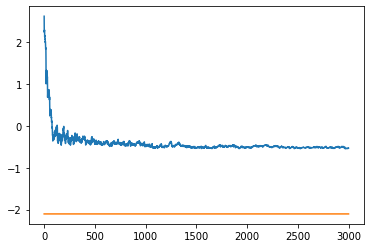

In [46]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

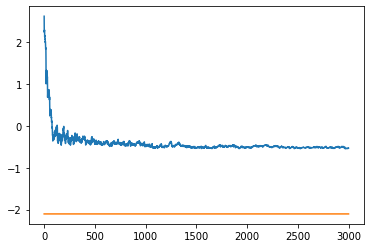

In [47]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [48]:
import pickle

file_to_store = open("VQE_Gunlycke_2_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [1]:
import pickle
T=1

file_to_read = open("VQE_Gunlycke_2_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

NameError: name 'A' is not defined

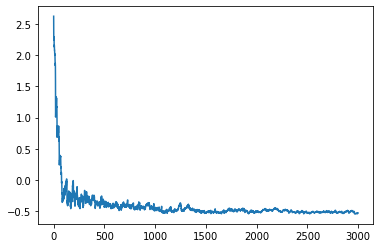

In [54]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [55]:
loaded_object[2999]

{'E': -0.5284618712191567,
 'c': 0.17818483720414563,
 'a': 0.00999489275991702,
 'phi': array([[[ 1.69652004, -0.67314092, -2.33222195]],
 
        [[ 0.26071816,  0.22306364,  1.77078144]],
 
        [[-0.1782175 , -0.19935836, -0.24239512]],
 
        [[-0.12359584,  0.11211425, -1.81682013]],
 
        [[-0.12675018, -0.11485349, -0.57878931]],
 
        [[ 0.04708688, -0.00986227, -0.39366958]]]),
 'Delta': array([[[ 1., -1., -1.]],
 
        [[ 1., -1., -1.]],
 
        [[-1., -1.,  1.]],
 
        [[-1., -1., -1.]],
 
        [[-1., -1.,  1.]],
 
        [[ 1.,  1., -1.]]]),
 'c_a': 0.17818483720414563,
 'a_a': 0.00999489275991702,
 'alpha': array([-0.00625283, -0.10119893,  0.02267974,  0.10013843,  0.2299402 ,
         0.96244746]),
 'Delta_a': array([1., 1., 1., 1., 1., 1.])}

In [364]:
def SPSA_from_load(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    #alpha = 0.602
    alpha = 0.201
    A = 10
    a = 0.6
    gamma = 0.101
    c = 0.4
    phi_k = np.array(phi)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**alpha)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = loaded_object[k]['Delta']
        
            
        #Find E    
        E_A = find_E(phi_k + c_k*Delta_k, blocks, method = method)
        E_B = find_E(phi_k - c_k*Delta_k, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k

        
        #Calculate new E
        E_f = np.real(find_E(phi_k, blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [365]:
El,psi_f = SPSA_from_load(500,method = 'simple',hold = False)

k= 0 c_k= 0.4 a_k= 0.37053677789517936 g= 0.31221237166560845 E_A= (0.6483890629959139+0j) E_B= (0.39861916566342714+0j) E_f= -0.2941674404659663
k= 1 c_k= 0.372954594574733 a_k= 0.36411269399518237 g= -0.26600035420340845 E_A= (0.2901614058922417+0j) E_B= (0.48857351440957686+0j) E_f= -0.2754518896460993
k= 2 c_k= 0.3579898757427053 a_k= 0.35830150846605 g= -0.23292677706300263 E_A= (0.29719469765243134+0j) E_B= (0.4639655536082976+0j) E_f= -0.2587121931480509
k= 3 c_k= 0.34773782403600867 a_k= 0.3530039095073033 g= 0.21234021146877308 E_A= (0.4327031217365752+0j) E_B= (0.28502567555358105+0j) E_f= -0.2459624290385531
k= 4 c_k= 0.33998833831625347 a_k= 0.3481423907099719 g= -0.8282619743549222 E_A= (0.03284742681671075+0j) E_B= (0.5960462515196494+0j) E_f= -0.08100027444187621
k= 5 c_k= 0.3337849224236992 a_k= 0.3436553693939271 g= -0.7447356728411818 E_A= (0.2115041071735653+0j) E_B= (0.7086671847444759+0j) E_f= 0.038152202417291815
k= 6 c_k= 0.32862839767254015 a_k= 0.33949315101716

k= 52 c_k= 0.267860162826851 a_k= 0.2609058398079971 g= -0.6637781002455034 E_A= (-1.0971474553042815+0j) E_B= (-0.7415480352789647+0j) E_f= -1.0994263698402225
k= 53 c_k= 0.26735494522142605 a_k= 0.26008126905440593 g= 1.407911354082114 E_A= (-0.5476712911724904+0j) E_B= (-1.3004954170669851+0j) E_f= -1.2750908604996083
k= 54 c_k= 0.2668599250350944 a_k= 0.2592720285936403 g= 0.3115613639478683 E_A= (-1.0104499459650993+0j) E_B= (-1.176736430419019+0j) E_f= -1.2814667599546898
k= 55 c_k= 0.26637471655715955 a_k= 0.25847760404433856 g= 0.1171148371603351 E_A= (-1.027592537004671+0j) E_B= (-1.0899854001111153+0j) E_f= -1.2818743830349033
k= 56 c_k= 0.2658989552298248 a_k= 0.2576975057492954 g= 0.5293579784046106 E_A= (-0.8792011062133299+0j) E_B= (-1.1607125730140462+0j) E_f= -1.282086350580811
k= 57 c_k= 0.26543229614067565 a_k= 0.2569312672388709 g= -0.139467602267511 E_A= (-1.0908689506251905+0j) E_B= (-1.0168305388109906+0j) E_f= -1.2801628270984842
k= 58 c_k= 0.26497441264651617 a_

k= 103 c_k= 0.25023014297472496 a_k= 0.23158657254318332 g= 0.16197514333165727 E_A= (-1.5241987206105965+0j) E_B= (-1.6052608471590608+0j) E_f= -1.7613944770531855
k= 104 c_k= 0.24998840873867942 a_k= 0.23118038596666274 g= -0.10559690922187386 E_A= (-1.610454788001996+0j) E_B= (-1.5576587813937979+0j) E_f= -1.76175682998874
k= 105 c_k= 0.24974919607452548 a_k= 0.2307784194017882 g= 0.23095575564585205 E_A= (-1.5114396716308858+0j) E_B= (-1.626801700233558+0j) E_f= -1.7663220086037088
k= 106 c_k= 0.2495124552599996 a_k= 0.23038059318858709 g= 0.35943278297641235 E_A= (-1.4573368947696406+0j) E_B= (-1.636702807132399+0j) E_f= -1.7735644700799984
k= 107 c_k= 0.24927813800651724 a_k= 0.22998682983541768 g= 0.3459481684476991 E_A= (-1.506252183827228+0j) E_B= (-1.6787268143820429+0j) E_f= -1.781116290224153
k= 108 c_k= 0.24904619740500722 a_k= 0.22959705394216187 g= -0.07873932143333032 E_A= (-1.6728575169562512+0j) E_B= (-1.6336380597778082+0j) E_f= -1.7823494830513171
k= 109 c_k= 0.2488

k= 153 c_k= 0.24050294487280224 a_k= 0.21526213181371276 g= 0.008744785336365263 E_A= (-1.7012406417363366+0j) E_B= (-1.7054469349876893+0j) E_f= -1.8713081976727461
k= 154 c_k= 0.24034577371294386 a_k= 0.2149992661706627 g= 0.22835649338188035 E_A= (-1.6435933200044097+0j) E_B= (-1.7533623561728953+0j) E_f= -1.8746302585197436
k= 155 c_k= 0.2401897150315199 a_k= 0.2147383069429348 g= -0.11426817501444562 E_A= (-1.7170791951622109+0j) E_B= (-1.6621871143744278+0j) E_f= -1.8751852786255994
k= 156 c_k= 0.24003475389827156 a_k= 0.21447922894421484 g= -0.28188096762304243 E_A= (-1.780900692284657+0j) E_B= (-1.6455782349006498+0j) E_f= -1.8829435060946635
k= 157 c_k= 0.23988087567680955 a_k= 0.21422200746922634 g= -0.1585448649172057 E_A= (-1.6936271332024946+0j) E_B= (-1.617563371141693+0j) E_f= -1.884116907322624
k= 158 c_k= 0.239728066017013 a_k= 0.21396661828174487 g= -0.16711155153215504 E_A= (-1.7323649605872646+0j) E_B= (-1.6522423024714528+0j) E_f= -1.8846123935717023
k= 159 c_k= 0.

k= 203 c_k= 0.23376922896323718 a_k= 0.20405069669827428 g= 0.13578834536009146 E_A= (-1.6945963510230346+0j) E_B= (-1.7580826246170793+0j) E_f= -1.9496523984210854
k= 204 c_k= 0.23365380153244633 a_k= 0.2038595775662753 g= -0.055417386332366134 E_A= (-1.7638914421314666+0j) E_B= (-1.7379944761563675+0j) E_f= -1.950437165964479
k= 205 c_k= 0.23353899237344763 a_k= 0.20366952306447533 g= -0.11792461007270193 E_A= (-1.795947970823381+0j) E_B= (-1.74086798159856+0j) E_f= -1.9518037972365203
k= 206 c_k= 0.23342479519724088 a_k= 0.20348052237451628 g= -0.09071368922306194 E_A= (-1.6991096595159274+0j) E_B= (-1.6567600108589686+0j) E_f= -1.9520031840421188
k= 207 c_k= 0.23331120380879006 a_k= 0.20329256483718383 g= 0.0483423105819938 E_A= (-1.7528395583647574+0j) E_B= (-1.7753971637183241+0j) E_f= -1.9525761027164394
k= 208 c_k= 0.2331982121051757 a_k= 0.20310563994934921 g= -0.0935832220514162 E_A= (-1.7761447814022004+0j) E_B= (-1.7324979012713366+0j) E_f= -1.9536927717094683
k= 209 c_k= 0

k= 253 c_k= 0.22865030548461726 a_k= 0.19561802104402623 g= 0.0493258290739389 E_A= (-1.7798753465321824+0j) E_B= (-1.8024320783042587+0j) E_f= -1.9759434919769092
k= 254 c_k= 0.22855958199258958 a_k= 0.19546942243156754 g= -0.057220595838998106 E_A= (-1.798263763672948+0j) E_B= (-1.7721071327402913+0j) E_f= -1.9763447043090334
k= 255 c_k= 0.22846924936970905 a_k= 0.19532149575799884 g= 0.05709263782042086 E_A= (-1.7882460155971356+0j) E_B= (-1.814333839811872+0j) E_f= -1.9766798247858155
k= 256 c_k= 0.22837930441497245 a_k= 0.19517423547591145 g= 0.031779577093912076 E_A= (-1.801824982732855+0j) E_B= (-1.8163405781554742+0j) E_f= -1.976889071770436
k= 257 c_k= 0.22828974396591784 a_k= 0.1950276361042541 g= 0.03729601650757049 E_A= (-1.791113483104523+0j) E_B= (-1.8081420792234468+0j) E_f= -1.9768232738242546
k= 258 c_k= 0.22820056489801344 a_k= 0.19488169222729543 g= 0.006766089520059693 E_A= (-1.820123037684761+0j) E_B= (-1.8232110885860173+0j) E_f= -1.9768788105756334
k= 259 c_k= 0.

k= 303 c_k= 0.2245379531555281 a_k= 0.1889158475879403 g= -0.019615701884670322 E_A= (-1.7602038357017515+0j) E_B= (-1.7513948965999657+0j) E_f= -1.98032834121638
k= 304 c_k= 0.22446348815402628 a_k= 0.18879514811017423 g= -0.015041963527366373 E_A= (-1.807511441626499+0j) E_B= (-1.8007586984224224+0j) E_f= -1.9804480317890927
k= 305 c_k= 0.22438929147512626 a_k= 0.1886749079481776 g= -0.005379159727201483 E_A= (-1.7702282511470542+0j) E_B= (-1.7678141994672176+0j) E_f= -1.9804321975331283
k= 306 c_k= 0.2243153612798253 a_k= 0.18855512390879003 g= -0.034871426066510405 E_A= (-1.7960331364346231+0j) E_B= (-1.7803887433617192+0j) E_f= -1.9805199722103088
k= 307 c_k= 0.2242416957476633 a_k= 0.18843579283103418 g= -0.032066339120264485 E_A= (-1.7986848505079438+0j) E_B= (-1.7843036299864483+0j) E_f= -1.980643996427383
k= 308 c_k= 0.22416829307647623 a_k= 0.1883169115856913 g= 0.016437240735645058 E_A= (-1.8042523980589036+0j) E_B= (-1.811621814456097+0j) E_f= -1.9806908605402178
k= 309 c_k

k= 353 c_k= 0.22111115942370668 a_k= 0.18338756003289805 g= 0.03882221520856018 E_A= (-1.7998008757955735+0j) E_B= (-1.8169689258278963+0j) E_f= -1.9820295317492296
k= 354 c_k= 0.2210481719458794 a_k= 0.18328646055073458 g= 0.0071509458131375405 E_A= (-1.8159274534849292+0j) E_B= (-1.8190888604842854+0j) E_f= -1.982010473015273
k= 355 c_k= 0.22098537951573047 a_k= 0.18318569318138667 g= -0.0019019534642685481 E_A= (-1.8242452398534958+0j) E_B= (-1.8234046320372506+0j) E_f= -1.9820130283647297
k= 356 c_k= 0.22092278098392504 a_k= 0.18308525593090869 g= -0.0038706887352812466 E_A= (-1.8230589603195704+0j) E_B= (-1.8213487136801274+0j) E_f= -1.981995495332018
k= 357 c_k= 0.2208603752110963 a_k= 0.1829851468227179 g= -0.02755966959595011 E_A= (-1.7940244271544605+0j) E_B= (-1.7818507492191498+0j) E_f= -1.9818850452459345
k= 358 c_k= 0.22079816106773162 a_k= 0.1828853638973968 g= -0.025775513851473135 E_A= (-1.7944604951253116+0j) E_B= (-1.7830781230073494+0j) E_f= -1.98201530577851
k= 359 

k= 403 c_k= 0.2181802692919501 a_k= 0.178703962236058 g= -0.010292584394149944 E_A= (-1.8269843762250224+0j) E_B= (-1.822493098555371+0j) E_f= -1.9821872263662588
k= 404 c_k= 0.2181257984204375 a_k= 0.17861732579176134 g= -0.01397943804524545 E_A= (-1.8192733892152475+0j) E_B= (-1.813174837045071+0j) E_f= -1.9821662925072885
k= 405 c_k= 0.2180714754281335 a_k= 0.17853093970918948 g= 0.004043741360277849 E_A= (-1.7976272361660897+0j) E_B= (-1.7993908854554608+0j) E_f= -1.9821446936108817
k= 406 c_k= 0.2180172995508166 a_k= 0.17844480266562 g= 0.005504211774597279 E_A= (-1.7852497522691575+0j) E_B= (-1.7876497790436645+0j) E_f= -1.982131343482575
k= 407 c_k= 0.21796327003008015 a_k= 0.17835891334846937 g= 0.0011722443329561072 E_A= (-1.801086633472+0j) E_B= (-1.8015976458881706+0j) E_f= -1.9821261851195617
k= 408 c_k= 0.2179093861132739 a_k= 0.1782732704551914 g= 0.00961478644325766 E_A= (-1.8063669744072754+0j) E_B= (-1.8105572788301965+0j) E_f= -1.982162633667444
k= 409 c_k= 0.21785564

k= 453 c_k= 0.2156241250645643 a_k= 0.17465504553076158 g= 0.009446685368866442 E_A= (-1.8186774143847995+0j) E_B= (-1.8227512809196436+0j) E_f= -1.9826608724809287
k= 454 c_k= 0.21557621389665993 a_k= 0.17457948453338862 g= 0.0191982866251469 E_A= (-1.8247353705263607+0j) E_B= (-1.8330127584142648+0j) E_f= -1.9827637711465338
k= 455 c_k= 0.21552841852324142 a_k= 0.17450411844306418 g= -0.011228681778111526 E_A= (-1.803329787273987+0j) E_B= (-1.7984895872225128+0j) E_f= -1.9827469403049183
k= 456 c_k= 0.21548073841143345 a_k= 0.17442894634039197 g= -0.00574623040761278 E_A= (-1.7894589045678506+0j) E_B= (-1.7869825006252213+0j) E_f= -1.9827223173735788
k= 457 c_k= 0.2154331730319722 a_k= 0.1743539673122692 g= -0.007685584631084743 E_A= (-1.8168967167008234+0j) E_B= (-1.8135852569334627+0j) E_f= -1.9826985403407287
k= 458 c_k= 0.21538572185917312 a_k= 0.1742791804518308 g= 0.0124803870127395 E_A= (-1.802406528289735+0j) E_B= (-1.8077827226213765+0j) E_f= -1.982694716952244
k= 459 c_k= 0

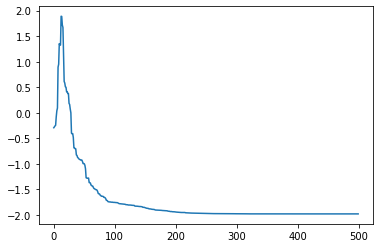

In [367]:
import matplotlib.pyplot as plt

tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [30]:
pwd

'C:\\Users\\jsten\\IBMQ\\Hubbard_symmetries'